# Memecoin active trading strategy on Base

- Add Aave credit

# Set up

Set up Trading Strategy data client.


In [35]:
import logging

from tradingstrategy.client import Client
from tradeexecutor.utils.notebook import setup_charting_and_output, OutputMode

client = Client.create_jupyter_client()

# Set up drawing charts in interactive vector output mode.
# This is slower. See the alternative commented option below.
# setup_charting_and_output(OutputMode.interactive)

# Set up rendering static PNG images.
# This is much faster but disables zoom on any chart.
setup_charting_and_output(OutputMode.static, image_format="png", width=1500, height=1000)


Started Trading Strategy in Jupyter notebook environment, configuration is stored in /Users/moo/.tradingstrategy


# Parameters

- Collection of parameters used in the calculations

In [36]:
import datetime

import pandas as pd

from tradingstrategy.chain import ChainId
from tradingstrategy.timebucket import TimeBucket
from tradeexecutor.strategy.cycle import CycleDuration
from tradeexecutor.strategy.parameters import StrategyParameters
from tradeexecutor.strategy.default_routing_options import TradeRouting


class Parameters:

    id = "30-base-macd-init"

    # We trade 1h candle
    candle_time_bucket = TimeBucket.h1
    cycle_duration = CycleDuration.cycle_4h
    
    # Coingecko categories to include
    #
    # See list here: TODO
    #
    chain_id = ChainId.base
    categories = {"Meme"}
    exchanges = {"uniswap-v2", "uniswap-v3"}
    
    #
    # Basket construction and rebalance parameters
    #
    min_asset_universe = 10  # How many assets we need in the asset universe to start running the index
    max_assets_in_portfolio = 7  # How many assets our basket can hold once
    allocation = 0.95  # Allocate all cash to volatile pairs
    # min_rebalance_trade_threshold_pct = 0.05  # % of portfolio composition must change before triggering rebalacne
    individual_rebalance_min_threshold_usd = 75.0  # Don't make buys less than this amount
    per_position_cap_of_pool = 0.01  # Never own more than % of the lit liquidity of the trading pool
    max_concentration = 0.20 # How large % can one asset be in a portfolio once
    min_portfolio_weight = 0.0050  # Close position / do not open if weight is less than 50 BPS
    min_signal_threshold = 0.125

    macd_fast = 4 * 12
    macd_slow = 4 * 26
    macd_signal = 4 * 9
    
    #
    # Inclusion criteria parameters:
    # - We set the length of various indicators used in the inclusion criteria
    # - We set minimum thresholds neede to be included in the index to filter out illiquid pairs
    #

    # For the length of trailing sharpe used in inclusion criteria
    trailing_sharpe_bars = pd.Timedelta("14d") // candle_time_bucket.to_timedelta()  # How many bars to use in trailing sharpe indicator
    rebalance_volalitity_bars = pd.Timedelta("1d") // candle_time_bucket.to_timedelta()  # How many bars to use in volatility indicator
    returns_bars = pd.Timedelta("10d") // candle_time_bucket.to_timedelta()  # How many bars to use in volatility indicator
    rolling_volume_bars = pd.Timedelta("7d") // candle_time_bucket.to_timedelta()
    rolling_liquidity_bars = pd.Timedelta("7d") // candle_time_bucket.to_timedelta()
    ewm_span = 200  # How many bars to use in exponential moving average for trailing sharpe smoothing
    tvl_ewm_span = 200  # How many bars to use in EWM smoothing of TVLs
    min_volume = 50_000   # USD
    min_liquidity = 200_000  # USD
    min_tvl = 25_000  # USD
    min_token_sniffer_score = 30  # Scam filter

    #
    # Yield on cash
    #
    use_aave = True

    #     
    #
    # Backtesting only
    #
    backtest_start = datetime.datetime(2024, 4, 1)
    backtest_end = datetime.datetime(2025, 1, 9)
    initial_cash = 10_000

    #
    # Live only
    #
    routing = TradeRouting.default
    required_history_period = datetime.timedelta(days=2*14 + 1)
    slippage_tolerance = 0.0060  # 0.6% 
    assummed_liquidity_when_data_missings = 10_000
    

parameters = StrategyParameters.from_class(Parameters)  # Convert to AttributedDict to easier typing with dot notation

# Trading pairs and market data

- This creates the strategy universe containing pair metadata and their prices
- The universe is "masked" by simply selecting pairs on the predefined pairs list

In [37]:
import warnings

from tradingstrategy.alternative_data.coingecko import CoingeckoUniverse, categorise_pairs
from tradingstrategy.chain import ChainId
from tradingstrategy.client import Client
from tradingstrategy.pair import PandasPairUniverse
from tradingstrategy.utils.token_filter import deduplicate_pairs_by_volume
from tradingstrategy.client import Client
from tradingstrategy.client import Client
from tradingstrategy.utils.token_extra_data import filter_scams
from tradingstrategy.lending import LendingProtocolType

from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradeexecutor.strategy.execution_context import ExecutionContext, notebook_execution_context
from tradeexecutor.strategy.universe_model import UniverseOptions
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse, load_partial_data, OHLCVCandleType
from tradeexecutor.strategy.execution_context import ExecutionContext, notebook_execution_context
from tradeexecutor.strategy.universe_model import UniverseOptions
from tradeexecutor.analysis.pair import display_strategy_universe

from eth_defi.token import USDC_NATIVE_TOKEN


# We define our main trading universe,
# and then Ethereum mainnet as a validation set
if Parameters.chain_id == ChainId.base:
    SUPPORTING_PAIRS = [
        (ChainId.base, "uniswap-v2", "WETH", "USDC", 0.0030),  
        (ChainId.base, "uniswap-v3", "cbBTC", "WETH", 0.0030),    # Only trading since October
    ]

    EXAMINED_ASSETS = [
        "AIXBT", 
        "PEPE",
        "KEYCAT",
        "WETH",
    ]

elif Parameters.chain_id == ChainId.ethereum:
    SUPPORTING_PAIRS = [
        (ChainId.ethereum, "uniswap-v2", "WETH", "USDC", 0.0030),  
        (ChainId.ethereum, "uniswap-v3", "WBTC", "USDC", 0.0030),    # Only trading since October
    ]

    EXAMINED_ASSETS = [
        "PEPE",
        "Neiro",
        "APU",
        "WETH",
    ]

else:
    raise NotImplementedError("Chain not supported")


#: Needed for USDC credit
LENDING_RESERVES  = [
    (Parameters.chain_id, LendingProtocolType.aave_v3, "USDC"),
]


# Will be converted to cbBTC/ETH->USDC
VOL_PAIR = (Parameters.chain_id, "uniswap-v2", "WETH", "USDC", 0.0030)


def create_trading_universe(
    timestamp: datetime.datetime,
    client: Client,
    execution_context: ExecutionContext,
    universe_options: UniverseOptions,
) -> TradingStrategyUniverse:
    """Create the trading universe.

    - Load Trading Strategy full pairs dataset

    - Load built-in Coingecko top 1000 dataset
    
    - Get all DEX tokens for a certain Coigecko category

    - Load OHCLV data for these pairs

    - Load also BTC and ETH price data to be used as a benchmark
    """

    chain_id = Parameters.chain_id
    categories = Parameters.categories

    coingecko_universe = CoingeckoUniverse.load()
    print("Coingecko universe is", coingecko_universe)

    exchange_universe = client.fetch_exchange_universe()
    pairs_df = client.fetch_pair_universe().to_pandas()

    # Drop other chains to make the dataset smaller to work with
    chain_mask = pairs_df["chain_id"] == Parameters.chain_id.value
    pairs_df = pairs_df[chain_mask]

    # Pull out our benchmark pairs ids.
    # We need to construct pair universe object for the symbolic lookup.
    pair_universe = PandasPairUniverse(pairs_df, exchange_universe=exchange_universe)
    benchmark_pair_ids = [pair_universe.get_pair_by_human_description(desc).pair_id for desc in SUPPORTING_PAIRS]

    # Assign categories to all pairs
    category_df = categorise_pairs(coingecko_universe, pairs_df)

    # Get all trading pairs that are memecoin, across all coingecko data
    mask = category_df["category"].isin(categories)
    category_pair_ids = category_df[mask]["pair_id"]

    our_pair_ids = list(category_pair_ids) + benchmark_pair_ids

    # From these pair ids, see what trading pairs we have on Ethereum mainnet
    pairs_df = pairs_df[pairs_df["pair_id"].isin(our_pair_ids)]

    # Limit by DEX
    pairs_df = pairs_df[pairs_df["exchange_slug"].isin(Parameters.exchanges)]

    # Never deduplicate supporrting pars
    supporting_pairs_df = pairs_df[pairs_df["pair_id"].isin(benchmark_pair_ids)]
    
    # Deduplicate trading pairs - Choose the best pair with the best volume
    deduplicated_df = deduplicate_pairs_by_volume(pairs_df)
    pairs_df = pd.concat([deduplicated_df, supporting_pairs_df]).drop_duplicates(subset='pair_id', keep='first')

    print(
        f"Total {len(pairs_df)} pairs to trade on {chain_id.name} for categories {categories}",        
    )

    # Scam filter using TokenSniffer
    pairs_df = filter_scams(pairs_df, client, min_token_sniffer_score=Parameters.min_token_sniffer_score)
    pairs_df = pairs_df.sort_values("volume", ascending=False)

    uni_v2 = pairs_df.loc[pairs_df["exchange_slug"] == "uniswap-v2"]
    uni_v3 = pairs_df.loc[pairs_df["exchange_slug"] == "uniswap-v3"]
    print(f"Pairs on Uniswap v2: {len(uni_v2)}, Uniswap v3: {len(uni_v3)}")

    dataset = load_partial_data(
        client=client,
        time_bucket=Parameters.candle_time_bucket,
        pairs=pairs_df,
        execution_context=execution_context,
        universe_options=universe_options,
        liquidity=True,
        liquidity_time_bucket=TimeBucket.d1,  
        liquidity_query_type=OHLCVCandleType.tvl_v2,
        lending_reserves=LENDING_RESERVES,
    )

    reserve_asset = USDC_NATIVE_TOKEN[chain_id.value]

    strategy_universe = TradingStrategyUniverse.create_from_dataset(
        dataset,
        reserve_asset=reserve_asset,
        forward_fill=True,  # We got very gappy data from low liquid DEX coins
    )

    # Tag benchmark/routing pairs tokens so they can be separated from the rest of the tokens
    # for the index construction.
    strategy_universe.warm_up_data()
    for pair_id in benchmark_pair_ids:
        pair = strategy_universe.get_pair_by_id(pair_id)
        pair.other_data["benchmark"] = True

    return strategy_universe

    
strategy_universe = create_trading_universe(
    None,
    client,
    notebook_execution_context,
    UniverseOptions.from_strategy_parameters_class(Parameters, notebook_execution_context)
)

display_strategy_universe(strategy_universe)


Coingecko universe is <CoingeckoUniverse for 2460 tokens>
Total 67 pairs to trade on base for categories {'Meme'}
After scam filter we have 60 pairs
Scammy pair WAI - WETH, risk score 25.0, pool 0x42e212ce754e97d5582fca8475ea970de6e81b0f, token 0x6112b8714221bbd96ae0a0032a683e38b475d06c
Scammy pair GUAN - WETH, risk score 25.0, pool 0xb4bc690e35ff10327036ae8033b89863c0add929, token 0xcc0adb6c436eb1f65b2f27733bf926691b94c5f1
Scammy pair OSAK - WETH, risk score 25.0, pool 0xcfa7c4bb565915f1c4f9475e2a0536d31efad776, token 0xbfd5206962267c7b4b4a8b3d76ac2e1b2a5c4d5e
Scammy pair TMAI - WETH, risk score 0.0, pool 0x860dca8b0e583c59b2642921b9241cd991afca42, token 0xca4569949699d56e1834efe9f58747ca0f151b01
Scammy pair NYA - WETH, risk score nan, pool 0x783b62afd1d3a82956e8306e787210f1e2a1213a, token 0x38f9bf9dce51833ec7f03c9dc218197999999999
Scammy pair CAW - WETH, risk score 25.0, pool 0x110751cbf035862f59a10528dd54b9ac2b048906, token 0xdfbea88c4842d30c26669602888d746d30f9d60d
Scammy pair BYTE

Data missing warning: We asked OHLCV data for 60 trading pairs, but only got for 56 pairs. This is usually because time period 2024-04-01 00:00:00 - 2025-01-09 00:00:00 does not have OHLCV data for all asked pairs.


Loading TVL/liquidity data for 60 pairs:   0%|          | 0/60 [00:00<?, ?it/s]

/Users/moo/code/trade-executor/deps/trading-strategy/tradingstrategy/transport/cache.py:911: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



base quote    exchange  fee %      type:        price  \
id                                                                   
3746592      WETH  USDC  uniswap-v2    0.3  benchmark      3339.23   
3746955       NPC  WETH  uniswap-v2    0.3     traded         0.02   
3754117      toby  WETH  uniswap-v2    0.3     traded         0.00   
3761589     BENJI  WETH  uniswap-v2    0.3     traded         0.02   
3765407    BOOMER  WETH  uniswap-v2    0.3     traded         0.00   
3767188    KEYCAT  WETH  uniswap-v2    0.3     traded         0.00   
3769198   doginme  WETH  uniswap-v2    0.3     traded         0.00   
3781200    HIGHER  WETH  uniswap-v2    0.3     traded         0.01   
3848692      MOEW  WETH  uniswap-v2    0.3     traded  <not avail>   
3859182   ElonRWA  WETH  uniswap-v2    0.3     traded         0.00   
3862696       SKI  WETH  uniswap-v2    0.3     traded         0.21   
3998406       FEG  WETH  uniswap-v2    0.3     traded         0.00   
3998441   AEROBUD  WETH  uniswap-v2    0.3     traded         0.02   
3998905      BTCB  WETH  uniswap-v2    0.3     traded         0.59   
4094655    BAMBOO  WETH  uniswap-v2    0.3     traded         0.01   
4102225     RGOAT  USDC  uniswap-v2    0.3     traded         0.00   
4274191     wHOGE  WETH  uniswap-v2    0.3     traded         0.00   
4345739      CATE  WETH  uniswap-v2    0.3     traded         0.00   
4432834    KIBSHI  WETH  uniswap-v2    0.3     traded         0.00   
4568627     TOSHI  WETH  uniswap-v3    1.0     traded         0.00   
4568940     MOCHI  WETH  uniswap-v3    1.0     traded         0.00   
4569519     DEGEN  WETH  uniswap-v3    0.3     traded         0.01   
4569680       DOG  WETH  uniswap-v3    0.3     traded         0.00   
4570059      TYBG  WETH  uniswap-v3    1.0     traded         0.00   
4573559     BRETT  WETH  uniswap-v3    1.0     traded         0.12   
4600914   BITCOIN  WETH  uniswap-v3    1.0     traded         0.19   
4622192     $mfer  WETH  uniswap-v3    1.0     traded         0.02   
4622315       Mog  WETH  uniswap-v3    1.0     traded         0.00   
4623553      ANDY  WETH  uniswap-v3    1.0     traded         0.01   
4636992     CHOMP  WETH  uniswap-v3    0.3     traded         0.07   
4648495     TRUMP  WETH  uniswap-v3    1.0     traded         2.43   
4679183   MIGGLES  WETH  uniswap-v3    1.0     traded         0.05   
4681653     MARSO  WETH  uniswap-v3    1.0     traded         0.00   
4683036      PEPE  WETH  uniswap-v3    1.0     traded         0.00   
4703496     cbBTC  WETH  uniswap-v3    0.3  benchmark     94927.60   
4735647   RUSSELL  WETH  uniswap-v3    1.0     traded         0.00   
4739677       SPX  USDC  uniswap-v3    1.0     traded         1.32   
4740428      LUNA  WETH  uniswap-v3    1.0     traded         0.09   
4762108       LUM  WETH  uniswap-v3    1.0     traded         8.63   
4820526    GLUTEU  WETH  uniswap-v2    0.3     traded         0.01   
4834635      ANON  WETH  uniswap-v3    1.0     traded         0.01   
4881232     AKUMA  WETH  uniswap-v2    0.3     traded         0.00   
4909938        VU  WETH  uniswap-v3    1.0     traded         0.01   
4910380     VADER  WETH  uniswap-v3    1.0     traded         0.09   
4912540     AIXBT  USDC  uniswap-v3    0.3     traded         0.44   
4913705     HENLO  WETH  uniswap-v3    1.0     traded         0.00   
4928787     AGENT  WETH  uniswap-v3    1.0     traded         0.88   
4931804      KATA  WETH  uniswap-v3    1.0     traded         0.00   
4933380       FAI  WETH  uniswap-v3    1.0     traded         0.06   
4933784     SIMMI  WETH  uniswap-v3    1.0     traded         0.00   
4933787     TRUST  WETH  uniswap-v3    1.0     traded         0.01   
4940379      BOBO  WETH  uniswap-v3    1.0     traded         0.00   
4969960  DICKBUTT  WETH  uniswap-v3    1.0     traded         0.00   
5008263       GDP  WETH  uniswap-v3    0.3     traded         0.01   
5011078  Fartcoin  WETH  uniswap-v3    1.0     traded         0.00   
5065690    LOCKIN  WETH

### Asset to trading pair map

- Build a helper map
- Because we are operating on trading pairs, not on tokens, which are the base asset of a trading pair, we set up 
  this map to easily look up the selected trading pair by its symbol

In [38]:
from tradingstrategy.types import TokenSymbol
from tradeexecutor.state.identifier import TradingPairIdentifier

# Create base token symbol to pair map to help later
# Token
token_map: dict[TokenSymbol, TradingPairIdentifier] = {p.base.token_symbol: p for p in strategy_universe.iterate_pairs()}

# print(f"Pair count is {strategy_universe.get_pair_count()}")
# for symbol, pair in token_map.items():
#    print(f"{symbol} - #{pair.internal_id}")

# Tokens part of benchmark data, but not the strategy
benchmark_pair_ids = [p.internal_id for p in strategy_universe.iterate_pairs() if p.other_data.get("benchmark") is True]
category_pair_ids = [p.internal_id for p in strategy_universe.iterate_pairs() if p.other_data.get("benchmark") is not True]

print(f"Token map is {len(token_map)} assets")
print("Category trading pairs", len(category_pair_ids))
print("Benchmark trading pairs", len(benchmark_pair_ids))

Token map is 60 assets
Category trading pairs 58
Benchmark trading pairs 2


# Indicators

- Precalculate indicators used by the strategy

In [39]:
import pandas as pd
import numpy as np
from IPython.display import HTML
import pandas_ta

from tradeexecutor.strategy.execution_context import ExecutionContext
from tradeexecutor.strategy.pandas_trader.indicator import IndicatorSet, IndicatorSource
from tradeexecutor.strategy.parameters import StrategyParameters
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradeexecutor.strategy.pandas_trader.indicator import calculate_and_load_indicators_inline
from tradeexecutor.strategy.pandas_trader.indicator import IndicatorDependencyResolver
from tradeexecutor.state.types import USDollarAmount
from tradeexecutor.strategy.pandas_trader.indicator_decorator import IndicatorRegistry
from tradeexecutor.analysis.indicator import display_indicators


indicators = IndicatorRegistry()


@indicators.define()
def trailing_sharpe(
    close: pd.Series, 
    trailing_sharpe_bars: int
) -> pd.Series:
    """Calculate trailing 30d or so returns / standard deviation.

    :param length:
        Trailing period. 
    
    :return:
        Rolling cumulative returns / rolling standard deviation

        Note that this trailing sharpe is not annualised.
    """
    ann_factor = pd.Timedelta(days=365) / Parameters.candle_time_bucket.to_pandas_timedelta()
    returns = close.pct_change()
    mean_returns = returns.rolling(window=trailing_sharpe_bars).mean()    
    vol = returns.rolling(window=trailing_sharpe_bars).std()
    return mean_returns / vol * np.sqrt(ann_factor)


@indicators.define(dependencies=(trailing_sharpe,), source=IndicatorSource.dependencies_only_per_pair)
def trailing_sharpe_ewm(
    trailing_sharpe_bars: int,
    ewm_span: float,
    pair: TradingPairIdentifier,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """Expontentially weighted moving average for Sharpe.

    :param ewm_span:
        How many bars to consider in the EVM

    """
    trailing_sharpe = dependency_resolver.get_indicator_data(
        "trailing_sharpe",
        pair=pair,
        parameters={"trailing_sharpe_bars": trailing_sharpe_bars},
    )    
    ewm = trailing_sharpe.ewm(span=ewm_span)
    return ewm.mean()


@indicators.define()
def volatility(close: pd.Series, rebalance_volalitity_bars: int) -> pd.Series:
    """Calculate the rolling volatility for rebalancing the index for each decision cycle."""
    price_diff = close.pct_change()
    rolling_std = price_diff.rolling(window=rebalance_volalitity_bars).std()
    return rolling_std


@indicators.define()
def rolling_returns(
    close: pd.Series, 
    returns_bars: int    
) -> pd.Series:
    """Rolling returns for the signal period."""

    def _agg_func(window: pd.Series) -> float:

        if len(window) < 2:
            return 0

        try:
            return (window.iloc[-1] - window.iloc[0]) / window.iloc[0]
        except Exception as e:
            raise # Drop into the debugger here

    returns = close.rolling(window=returns_bars).agg(_agg_func)
    return returns


#@indicators.define(source=IndicatorSource.close_price)
#def rsi(
#    close: pd.Series, 
#    rsi_length: int,
#):
#    return pandas_ta.rsi(close, length=rsi_length)


@indicators.define(source=IndicatorSource.close_price)
def macd(
    close: pd.Series, 
    macd_fast: int,
    macd_slow: int,
    macd_signal: int,
):
    """
    https://github.com/twopirllc/pandas-ta/blob/b465491f226d9e07fffd4e59cd0affc9284521ca/pandas_ta/momentum/macd.py#L107
    """
    df = pandas_ta.macd(close, fast=macd_fast, slow=macd_slow, signal=macd_signal)
    macd_series = df[f"MACD_{macd_fast}_{macd_slow}_{macd_signal}"]
    return macd_series



@indicators.define(dependencies=[macd])
def signal(
    close: pd.Series, 
    macd_fast: int,
    macd_slow: int,
    macd_signal: int,
    pair: TradingPairIdentifier,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Figure out some indicator to predict the price."""

    macd = dependency_resolver.get_indicator_data(
        "macd",
        parameters={
            "macd_fast": macd_fast,
            "macd_slow": macd_slow,
            "macd_signal": macd_signal,
        },
        pair=pair,
    )
    return macd



@indicators.define()
def volatility_ewm(close: pd.Series, rebalance_volalitity_bars: int) -> pd.Series:
    """Calculate the rolling volatility for rebalancing the index for each decision cycle."""
    # We are operating on 1h candles, 14d window
    price_diff = close.pct_change()
    rolling_std = price_diff.rolling(window=rebalance_volalitity_bars).std()
    ewm = rolling_std.ewm(span=14*8)
    return ewm.mean()   


@indicators.define()
def mean_returns(close: pd.Series, rebalance_volalitity_bars: int) -> pd.Series:
    # Descripton: TODO
    returns = close.pct_change()
    mean_returns = returns.rolling(window=rebalance_volalitity_bars).mean()    
    return mean_returns


@indicators.define()
def rolling_cumulative_volume(volume: pd.Series, rolling_volume_bars: int) -> pd.Series:
    """Calculate rolling volume of the pair.
    
    - Used in inclusion criteria
    """
    rolling_volume = volume.rolling(window=rolling_volume_bars).sum()
    return rolling_volume


@indicators.define()
def rolling_liquidity_avg(close: pd.Series, rolling_volume_bars: int) -> pd.Series:
    """Calculate rolling liquidity average

    - This is either TVL or XY liquidity (one sided) depending on the trading pair DEX type
    
    - Used in inclusion criteria
    """
    rolling_liquidity_close = close.rolling(window=rolling_volume_bars).mean()
    return  rolling_liquidity_close

    
@indicators.define(dependencies=(rolling_cumulative_volume,), source=IndicatorSource.strategy_universe)
def volume_inclusion_criteria(   
    strategy_universe: TradingStrategyUniverse, 
    min_volume: USDollarAmount,
    rolling_volume_bars: int,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """Calculate pair volume inclusion criteria.

    - Avoid including illiquid / broken pairs in the set: Pair is included when it has enough volume 

    TODO: Add liquidity check later

    :return:
        Series where each timestamp is a list of pair ids meeting the criteria at that timestamp
    """

    series = dependency_resolver.get_indicator_data_pairs_combined(
        rolling_cumulative_volume,
        parameters={"rolling_volume_bars": rolling_volume_bars},
    )

    # Get mask for days when the rolling volume meets out criteria
    mask = series >= min_volume
    mask_true_values_only = mask[mask == True]

    # Turn to a series of lists
    series = mask_true_values_only.groupby(level='timestamp').apply(lambda x: x.index.get_level_values('pair_id').tolist())
    return series


@indicators.define(dependencies=(volatility_ewm,), source=IndicatorSource.strategy_universe)
def volatility_inclusion_criteria(   
    strategy_universe: TradingStrategyUniverse, 
    rebalance_volalitity_bars: int,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """Calculate volatility inclusion criteria.

    - Include pairs that are above our threshold signal

    :return:
        Series where each timestamp is a list of pair ids meeting the criteria at that timestamp
    """
    
    series = dependency_resolver.get_indicator_data_pairs_combined(
       volatility_ewm,
        parameters={"rebalance_volalitity_bars": rebalance_volalitity_bars},
    )

    threshold_pair = strategy_universe.get_pair_by_human_description(VOL_PAIR)
    assert threshold_pair
    threshold_signal = dependency_resolver.get_indicator_data(
        volatility_ewm,
        pair=threshold_pair,
        parameters={"rebalance_volalitity_bars": rebalance_volalitity_bars},
    )

    assert threshold_signal is not None, "No threshold volatility signal for: {threshold_pair}"

    # Get mask for days when the rolling volume meets out criteria,
    # and max out the threshold signal if there is
    # mask = filtered_series >= threshold_signal
    df = series.reset_index()
    df2 = df.merge(threshold_signal, on=["timestamp"], suffixes=('_pair', '_reference'))

    #         pair_id           timestamp  value_pair  value_reference
    # 0       4569519 2024-02-13 16:00:00    0.097836              NaN
    # 1       4569519 2024-02-13 17:00:00    0.097773              NaN

    high_volatility_rows = df2[df2["value_pair"] >= df2["value_reference"]]

    def _get_pair_ids_as_list(rows):
        return rows["pair_id"].tolist()
    
    # Turn to a series of lists
    series = high_volatility_rows.groupby(by=['timestamp']).apply(_get_pair_ids_as_list)
    assert isinstance(series, pd.Series)
    return series


@indicators.define(source=IndicatorSource.tvl)
def tvl(
    close: pd.Series,
) -> pd.Series:
    """Get TVL series for a pair.

    - Because TVL data is 1d and we use 1h everywhere else, we need to forward fill

    - Use previous hourly close as the value
    """
    return close.resample("1h").ffill()


@indicators.define(dependencies=(tvl,), source=IndicatorSource.dependencies_only_per_pair)
def tvl_ewm(
    pair: TradingPairIdentifier,
    tvl_ewm_span: float,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """Get smoothed TVL series for a pair.

    - Interpretation: If you set span=5, for example, the ewm function will compute an exponential moving average where the weight of the most recent observation is about 33.3% (since α=2/(5+1)≈0.333) and this weight decreases exponentially for older observations.

    - We forward fill gaps, so there is no missing data in decide_trades()    

    - Currently unused in the strategy itself
    """
    tvl_ff = dependency_resolver.get_indicator_data(
        tvl,
        pair=pair,
    )    
    return tvl_ff.ewm(span=tvl_ewm_span).mean()


@indicators.define(dependencies=(tvl,), source=IndicatorSource.dependencies_only_universe)
def tvl_inclusion_criteria(   
    min_tvl: USDollarAmount,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """The pair must have min XX,XXX USD one-sided TVL to be included.

    - If the Uniswap pool does not have enough ETH or USDC deposited, skip the pair as a scam

    :return:
        Series where each timestamp is a list of pair ids meeting the criteria at that timestamp
    """
    
    series = dependency_resolver.get_indicator_data_pairs_combined(tvl)
    mask = series >= min_tvl
    # Turn to a series of lists
    mask_true_values_only = mask[mask == True]
    series = mask_true_values_only.groupby(level='timestamp').apply(lambda x: x.index.get_level_values('pair_id').tolist())
    return series



@indicators.define(
    source=IndicatorSource.strategy_universe
)
def trading_availability_criteria(
    strategy_universe: TradingStrategyUniverse,
) -> pd.Series:
    """Is pair tradeable at each hour.

    - The pair has a price candle at that
    - Mitigates very corner case issues that TVL/liquidity data is per-day whileas price data is natively per 1h
      and the strategy inclusion criteria may include pair too early hour based on TVL only,
      leading to a failed attempt to rebalance in a backtest
    - Only relevant for backtesting issues if we make an unlucky trade on the starting date
      of trading pair listing

    :return:
        Series with with index (timestamp) and values (list of pair ids trading at that hour)
    """
    # Trading pair availability is defined if there is a open candle in the index for it.
    # Because candle data is forward filled, we should not have any gaps in the index.
    candle_series = strategy_universe.data_universe.candles.df["open"]
    pairs_per_timestamp = candle_series.groupby(level='timestamp').apply(lambda x: x.index.get_level_values('pair_id').tolist())
    return pairs_per_timestamp


@indicators.define(
    dependencies=[
        volume_inclusion_criteria,
        volatility_inclusion_criteria,
        tvl_inclusion_criteria,
        trading_availability_criteria
    ],
    source=IndicatorSource.strategy_universe
)
def inclusion_criteria(
    strategy_universe: TradingStrategyUniverse,
    min_volume: USDollarAmount,
    rolling_volume_bars: int,
    rebalance_volalitity_bars: int,
    min_tvl: USDollarAmount,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Pairs meeting all of our inclusion criteria.

    - Give the tradeable pair set for each timestamp

    :return:
        Series where index is timestamp and each cell is a list of pair ids matching our inclusion criteria at that moment
    """

    # Filter out benchmark pairs like WETH in the tradeable pair set
    benchmark_pair_ids = set(strategy_universe.get_pair_by_human_description(desc).internal_id for desc in SUPPORTING_PAIRS)

    volatility_series = dependency_resolver.get_indicator_data(
        volatility_inclusion_criteria,
        parameters={"rebalance_volalitity_bars": rebalance_volalitity_bars},
    )

    volume_series = dependency_resolver.get_indicator_data(
        volume_inclusion_criteria,
        parameters={
            "min_volume": min_volume,
            "rolling_volume_bars": rolling_volume_bars,
        },
    )

    tvl_series = dependency_resolver.get_indicator_data(
        tvl_inclusion_criteria,
        parameters={
            "min_tvl": min_tvl,
        },
    )

    trading_availability_series = dependency_resolver.get_indicator_data(trading_availability_criteria)

    #
    # Process all pair ids as a set and the final inclusion
    # criteria is union of all sub-criterias
    #

    df = pd.DataFrame({
        "tvl_pair_ids": tvl_series,
        "volume_pair_ids": volume_series,
        "volatility_pair_ids": volatility_series,
        "trading_availability_pair_ids": trading_availability_series,
    })

    # https://stackoverflow.com/questions/33199193/how-to-fill-dataframe-nan-values-with-empty-list-in-pandas
    df = df.fillna("").apply(list)

    # Volatility criteria removed so we get truly equally weighted index
    # def _combine_criteria(row):
    #     final_set = set(row["volume_pair_ids"]) & set(row["volatility_pair_ids"]) & set(row["tvl_pair_ids"])
    #     return final_set - benchmark_pair_ids

    def _combine_criteria(row):
        final_set = set(row["volume_pair_ids"]) & \
                    set(row["tvl_pair_ids"]) & \
                    set(row["trading_availability_pair_ids"])
        return final_set - benchmark_pair_ids

    union_criteria = df.apply(_combine_criteria, axis=1)

    # Inclusion criteria data can be spotty at the beginning when there is only 0 or 1 pairs trading,
    # so we need to fill gaps to 0
    full_index = pd.date_range(
        start=union_criteria.index.min(),
        end=union_criteria.index.max(),
        freq=Parameters.candle_time_bucket.to_frequency(),
    )
    reindexed = union_criteria.reindex(full_index, fill_value=[])
    return reindexed


@indicators.define(dependencies=(volume_inclusion_criteria,), source=IndicatorSource.dependencies_only_universe)
def volume_included_pair_count(
    min_volume: USDollarAmount,
    rolling_volume_bars: int,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    series = dependency_resolver.get_indicator_data(
        volume_inclusion_criteria,
        parameters={"min_volume": min_volume, "rolling_volume_bars": rolling_volume_bars},
    )
    return series.apply(len)


@indicators.define(dependencies=(volatility_inclusion_criteria,), source=IndicatorSource.dependencies_only_universe)
def volatility_included_pair_count(
    rebalance_volalitity_bars: int,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Calculate number of pairs in meeting volatility criteria on each timestamp"""
    series = dependency_resolver.get_indicator_data(
        volatility_inclusion_criteria,
        parameters={"rebalance_volalitity_bars": rebalance_volalitity_bars},
    )
    return series.apply(len)


@indicators.define(dependencies=(tvl_inclusion_criteria,), source=IndicatorSource.dependencies_only_universe)
def tvl_included_pair_count(
        min_tvl: USDollarAmount,
        dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Calculate number of pairs in meeting volatility criteria on each timestamp"""
    series = dependency_resolver.get_indicator_data(
        tvl_inclusion_criteria,
        parameters={"min_tvl": min_tvl},
    )
    series = series.apply(len)

    # TVL data can be spotty at the beginning when there is only 0 or 1 pairs trading,
    # so we need to fill gaps to 0
    full_index = pd.date_range(
        start=series.index.min(),
        end=series.index.max(),
        freq=Parameters.candle_time_bucket.to_frequency(),
    )
    # Reindex and fill NaN with zeros
    reindexed = series.reindex(full_index, fill_value=0)
    return reindexed



@indicators.define(dependencies=(inclusion_criteria,), source=IndicatorSource.dependencies_only_universe)
def all_criteria_included_pair_count(
    min_volume: USDollarAmount,
    min_tvl: USDollarAmount,
    rolling_volume_bars: int,
    rebalance_volalitity_bars: int,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Series where each timestamp is the list of pairs meeting all inclusion criteria.

    :return:
        Series with pair count for each timestamp
    """
    series = dependency_resolver.get_indicator_data(
        "inclusion_criteria",
        parameters={
            "min_volume": min_volume, 
            "min_tvl": min_tvl, 
            "rolling_volume_bars": rolling_volume_bars,
            "rebalance_volalitity_bars": rebalance_volalitity_bars,
        },
    )
    return series.apply(len)


@indicators.define(source=IndicatorSource.strategy_universe)
def trading_pair_count(
    strategy_universe: TradingStrategyUniverse,
) -> pd.Series:
    """Get number of pairs that trade at each timestamp.

    - Pair must have had at least one candle before the timestamp to be included

    - Exclude benchmarks pairs we do not trade

    :return:
        Series with pair count for each timestamp
    """

    benchmark_pair_ids = {strategy_universe.get_pair_by_human_description(desc).internal_id for desc in SUPPORTING_PAIRS}

    # Get pair_id, timestamp -> timestamp, pair_id index
    series = strategy_universe.data_universe.candles.df["open"]    
    swap_index = series.index.swaplevel(0, 1)

    seen_pairs = set()
    seen_data = {}

    for timestamp, pair_id in swap_index:
        if pair_id in benchmark_pair_ids:
            continue
        seen_pairs.add(pair_id)
        seen_data [timestamp] = len(seen_pairs)

    series = pd.Series(seen_data.values(), index=list(seen_data.keys()))
    return series


@indicators.define(dependencies=(volatility_ewm,), source=IndicatorSource.strategy_universe)
def volume_weighted_avg_volatility(
    strategy_universe,
    rebalance_volalitity_bars: int,
    dependency_resolver: IndicatorDependencyResolver
) -> pd.Series:
    """Calculate the volume-weighted volatility for the whole index.

    This does not make really sense, but we calculate anyway.

    :return:
        Series with pair count for each timestamp
    """

    volatility_series = dependency_resolver.get_indicator_data_pairs_combined(
        volatility_ewm,
        parameters={"rebalance_volalitity_bars": rebalance_volalitity_bars},
    )

    volume_series = strategy_universe.data_universe.candles.df["volume"]

    # Create DataFrames for easier manipulation
    df = pd.DataFrame({
        'volatility': volatility_series,
        'volume': volume_series
    })
        
    df['weighted'] = df['volatility'] * df['volume']

    # Group by timestamp and calculate weighted average
    grouped = df.groupby(level='timestamp')
    
    volume_weighted_volatility = (
        grouped['weighted'].sum() / grouped['volume'].sum()
    )
    
    return volume_weighted_volatility


display_indicators(indicators)


# Calculate all indicators where parameters have changed and store the result on disk
indicator_data = calculate_and_load_indicators_inline(
    strategy_universe=strategy_universe,
    create_indicators=indicators.create_indicators,
    parameters=parameters,
    max_workers=1,
)

We have 23 indicators:


Reading cached indicators trailing_sharpe, trailing_sharpe_ewm, volatility, rolling_returns, macd, signal, vol…

Using indicator cache /Users/moo/.cache/indicators/base_1h_60_2024-04-01-2025-01-09_ff


# Available pairs

- Number of pairs available to trade every month



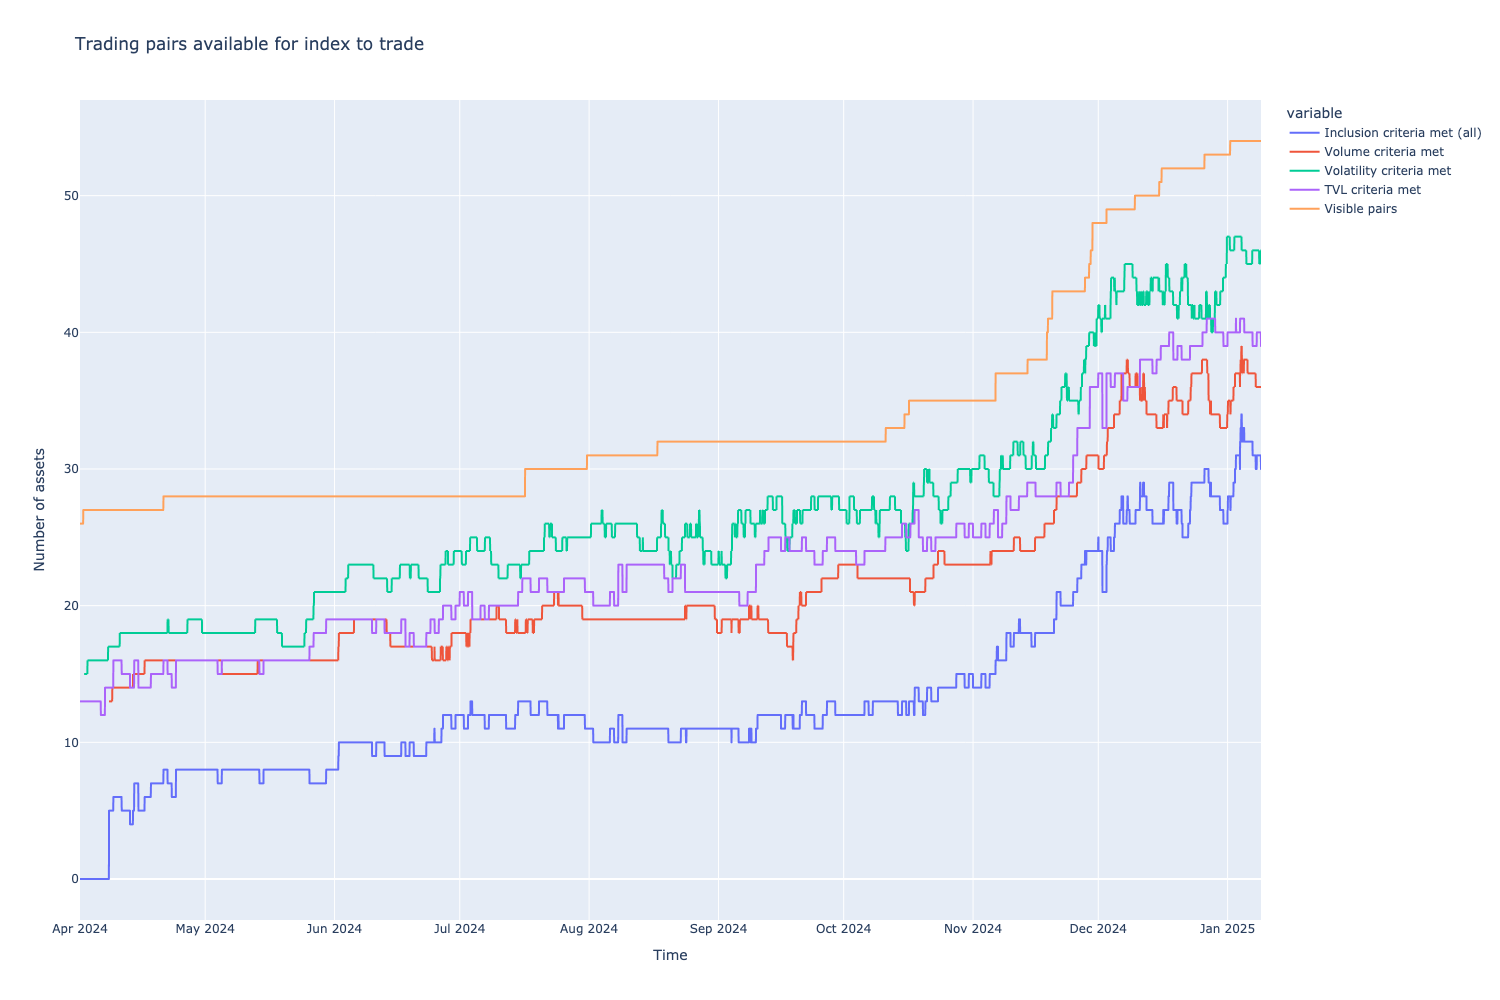

Inclusion criteria met (all)  Volume criteria met  \
2025-01-08 20:00:00                            31                 36.0   
2025-01-08 21:00:00                            31                 36.0   
2025-01-08 22:00:00                            31                 36.0   
2025-01-08 23:00:00                            31                 36.0   
2025-01-09 00:00:00                            30                 36.0   

                     Volatility criteria met  TVL criteria met  Visible pairs  
2025-01-08 20:00:00                     46.0                40             54  
2025-01-08 21:00:00                     46.0                40             54  
2025-01-08 22:00:00                     45.0                40             54  
2025-01-08 23:00:00                     45.0                40             54  
2025-01-09 00:00:00                     45.0                39             54

In [40]:
import plotly.express as px

df = pd.DataFrame({
    "Inclusion criteria met (all)": indicator_data.get_indicator_series("all_criteria_included_pair_count"),
    "Volume criteria met": indicator_data.get_indicator_series("volume_included_pair_count"),
    "Volatility criteria met": indicator_data.get_indicator_series("volatility_included_pair_count"),
    "TVL criteria met": indicator_data.get_indicator_series("tvl_included_pair_count"),
    "Visible pairs": indicator_data.get_indicator_series("trading_pair_count"),
})

fig = px.line(df, title='Trading pairs available for index to trade')
fig.update_yaxes(title="Number of assets")
fig.update_xaxes(title="Time")
fig.show()

display(df.tail(5))

Find the first availability, or admission to index, of all trading pairs.

In [41]:
series = indicator_data.get_indicator_series("inclusion_criteria")

exploded = series.explode()
first_appearance_series = exploded.groupby(exploded.values).apply(lambda x: x.index[0])

df = pd.DataFrame({
    "Included at": first_appearance_series
})

df["Ticker"] = first_appearance_series.index.map(lambda pair_id: strategy_universe.get_pair_by_id(pair_id).get_ticker())
df["DEX"] = first_appearance_series.index.map(lambda pair_id: strategy_universe.get_pair_by_id(pair_id).exchange_name)
df = df.sort_values("Included at")

def _map_tvl(row):
    pair_id = row.name  # Indxe
    timestamp = row["Included at"]
    tvl, delay = strategy_universe.data_universe.liquidity.get_liquidity_with_tolerance(
        pair_id,
        timestamp,
        tolerance=pd.Timedelta(days=2),
    )
    return tvl

# Get the first entry and value of rolling cum volume of each pair
volume_series = indicator_data.get_indicator_data_pairs_combined("rolling_cumulative_volume")
first_volume_df = volume_series.reset_index().groupby("pair_id").first()

def _map_volume_timestamp(row):
    pair_id = row.name  # Index
    try:
        return first_volume_df.loc[pair_id]["timestamp"]
    except KeyError:
        return None
    
def _map_volume_value(row):
    pair_id = row.name  # Index
    try:
        return first_volume_df.loc[pair_id]["value"]
    except KeyError:
        return None

df["TVL at inclusion"] = df.apply(_map_tvl, axis=1)
df["Rolling volume first entry at"] = df.apply(_map_volume_timestamp, axis=1)
df["Rolling volume initial"] = df.apply(_map_volume_value, axis=1)

print(f"First appearances of {len(df)} trading pairs, when they meet all inclusion criteria:")

with pd.option_context("display.float_format", "{:,.2f}".format):
    display(df)


First appearances of 39 trading pairs, when they meet all inclusion criteria:


Included at         Ticker         DEX  TVL at inclusion  \
4568627 2024-04-07 23:00:00     TOSHI-WETH  uniswap-v3      6,364,640.50   
4568940 2024-04-07 23:00:00     MOCHI-WETH  uniswap-v3        159,433.18   
4569519 2024-04-07 23:00:00     DEGEN-WETH  uniswap-v3     17,462,865.92   
4573559 2024-04-07 23:00:00     BRETT-WETH  uniswap-v3      4,409,076.97   
4570059 2024-04-07 23:00:00      TYBG-WETH  uniswap-v3         61,325.94   
4622192 2024-04-09 00:00:00     $mfer-WETH  uniswap-v3      4,381,442.69   
4622315 2024-04-13 17:00:00       Mog-WETH  uniswap-v3        113,068.92   
3862696 2024-04-16 12:00:00       SKI-WETH  uniswap-v2        313,433.95   
3761589 2024-06-01 22:00:00     BENJI-WETH  uniswap-v2        730,074.15   
3746955 2024-06-02 01:00:00       NPC-WETH  uniswap-v2        533,998.34   
4094655 2024-06-24 22:00:00    BAMBOO-WETH  uniswap-v2         52,274.35   
4102225 2024-06-26 15:00:00     RGOAT-USDC  uniswap-v2         41,672.85   
4600914 2024-07-03 14:00:00   BITCOIN-WETH  uniswap-v3         65,112.91   
4683036 2024-08-24 08:00:00      PEPE-WETH  uniswap-v3        819,209.01   
4740428 2024-10-16 16:00:00      LUNA-WETH  uniswap-v3            280.02   
3998441 2024-10-18 01:00:00   AEROBUD-WETH  uniswap-v2        128,971.58   
4679183 2024-10-23 15:00:00   MIGGLES-WETH  uniswap-v3        107,370.84   
4820526 2024-11-06 10:00:00    GLUTEU-WETH  uniswap-v2         25,490.94   
4648495 2024-11-06 17:00:00     TRUMP-WETH  uniswap-v3             30.24   
4762108 2024-11-15 21:00:00       LUM-WETH  uniswap-v3      2,058,079.85   
3998905 2024-11-21 00:00:00      BTCB-WETH  uniswap-v2        776,574.34   
4834635 2024-11-21 01:00:00      ANON-WETH  uniswap-v3      1,659,712.69   
4910380 2024-11-26 00:00:00     VADER-WETH  uniswap-v3         35,046.85   
4913705 2024-11-26 23:00:00     HENLO-WETH  uniswap-v3         37,910.78   
4928787 2024-11-27 20:00:00     AGENT-WETH  uniswap-v3              0.22   
4912540 2024-11-28 04:00:00     AIXBT-USDC  uniswap-v3      1,524,188.82   
4881232 2024-12-03 02:00:00     AKUMA-WETH  uniswap-v2        213,787.42   
3767188 2024-12-04 19:00:00    KEYCAT-WETH  uniswap-v2      2,379,713.38   
4933380 2024-12-06 04:00:00       FAI-WETH  uniswap-v3        772,841.07   
4933784 2024-12-06 14:00:00     SIMMI-WETH  uniswap-v3      3,680,559.97   
4569680 2024-12-07 20:00:00       DOG-WETH  uniswap-v3         24,367.55   
4933787 2024-12-08 00:00:00     TRUST-WETH  uniswap-v3         26,568.81   
4735647 2024-12-09 23:00:00   RUSSELL-WETH  uniswap-v3         24,821.79   
4969960 2024-12-16 18:00:00  DICKBUTT-WETH  uniswap-v3        352,932.48   
5008263 2024-12-22 14:00:00       GDP-WETH  uniswap-v3      1,064,821.34   
5011078 2024-12-23 04:00:00  Fartcoin-WETH  uniswap-v3        602,831.77   
5065690 2024-12-26 11:00:00    LOCKIN-WETH  uniswap-v2        723,962.24   
4739677 2024-12-27 23:00:00       SPX-USDC  uniswap-v3         83,012.89   
4940379 2025-01-02 10:00:00      BOBO-WETH  uniswap-v3        100,078.45   

        Rolling volume first entry at  Rolling volume initial  
4568627           2024-04-01 00:00:00           27,387,790.68  
4568940           2024-04-06 18:00:00            2,244,249.27  
4569519           2024-04-01 00:00:00          278,630,893.28  
4573559           2024-04-01 00:00:00           47,476,988.46  
4570059           2024-04-01 00:00:00            2,707,821.43  
4622192           2024-04-01 00:00:00           82,503,301.07  
4622315           2024-04-01 00:00:00            3,027,957.32  
3862696           2024-04-09 13:00:00           21,754,259.94  
3761589           2024-04-01 00:00:00           14,821,198.70  
3746955           2024-04-01 00:00:00              414,425.63  
4094655           2024-06-24 22:00:00               23,818.05  
4102225           2024-06-26 15:00:00            1,170,987.44  
4600914           2024-04-01 00:00:00              156,704.90  
4683036           2024-08-17 09:00:00            2,712,086.77  
4740428        

# Price vs. signal

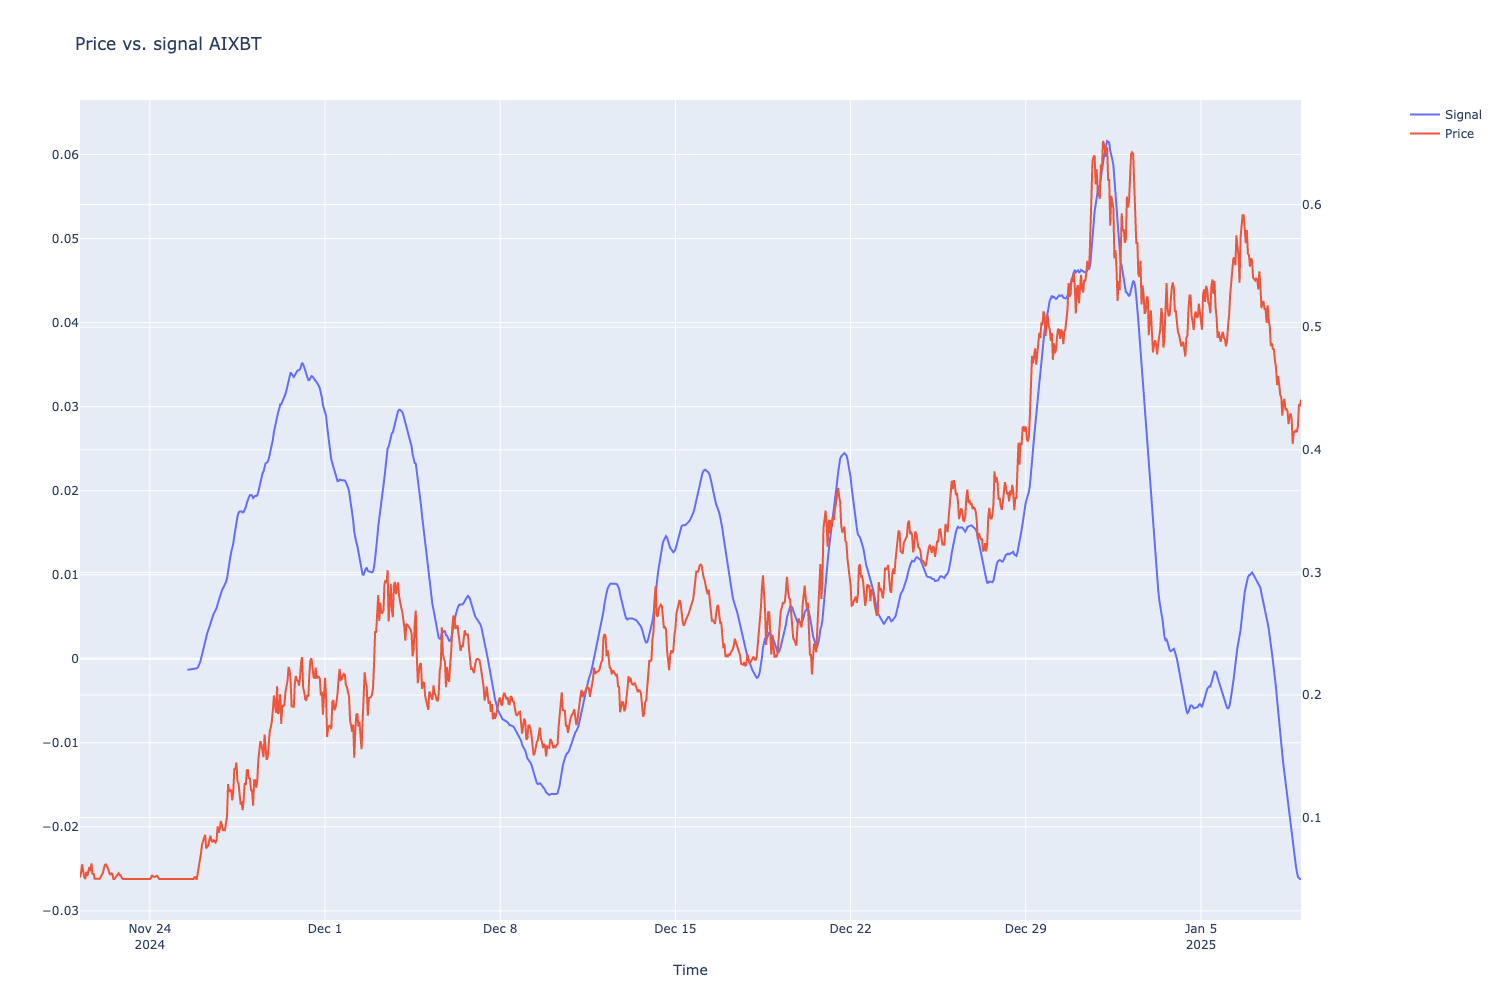

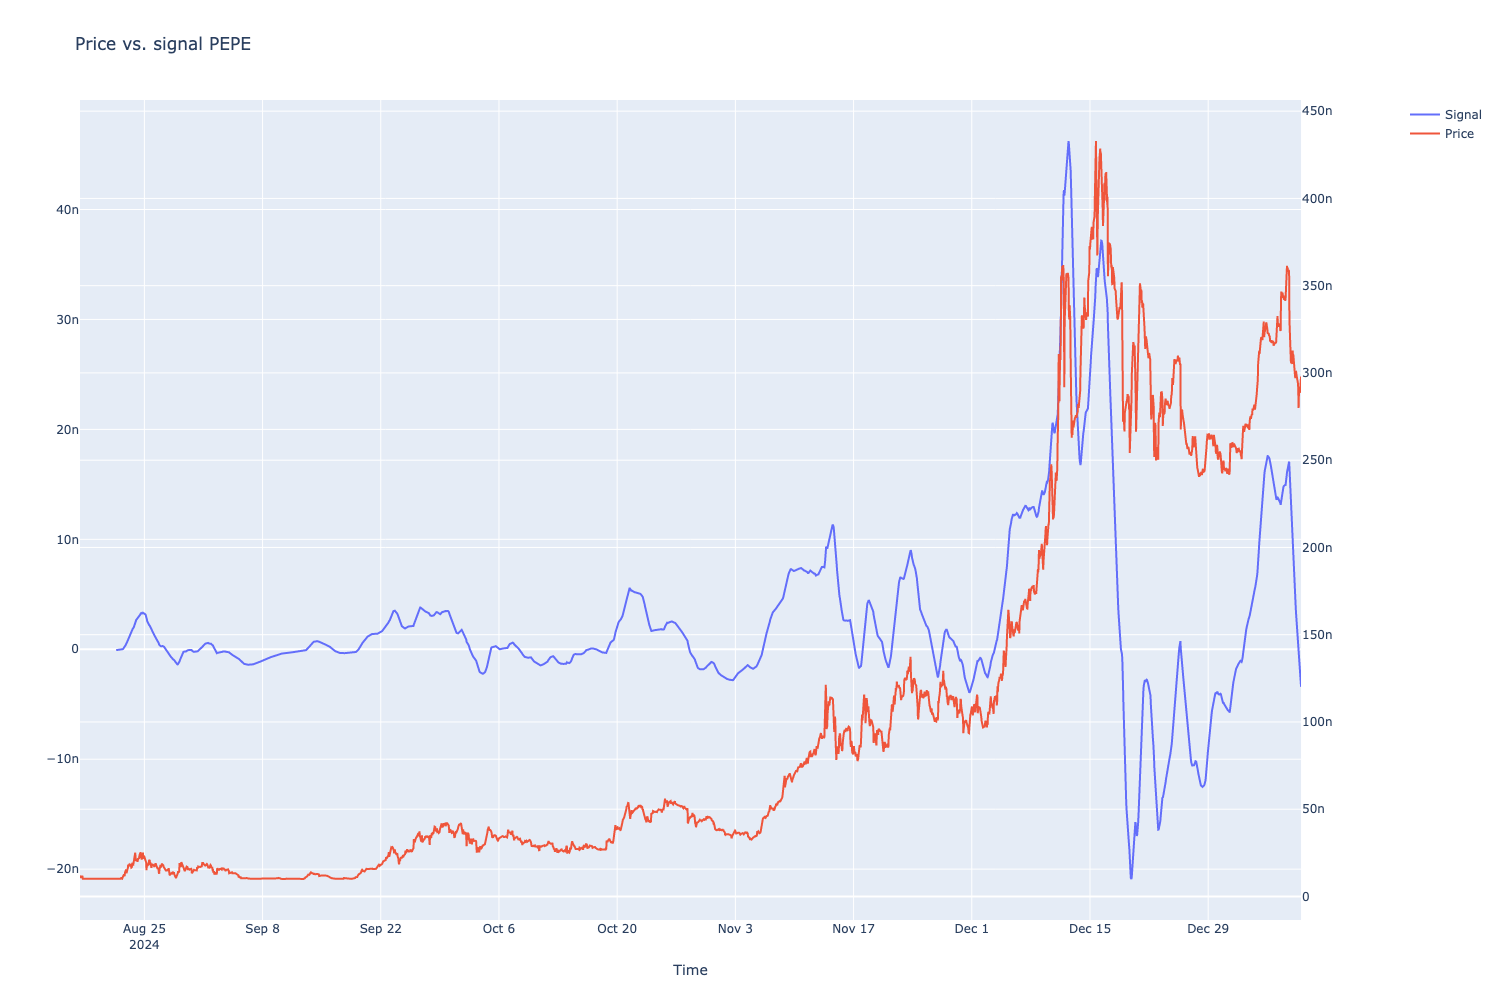

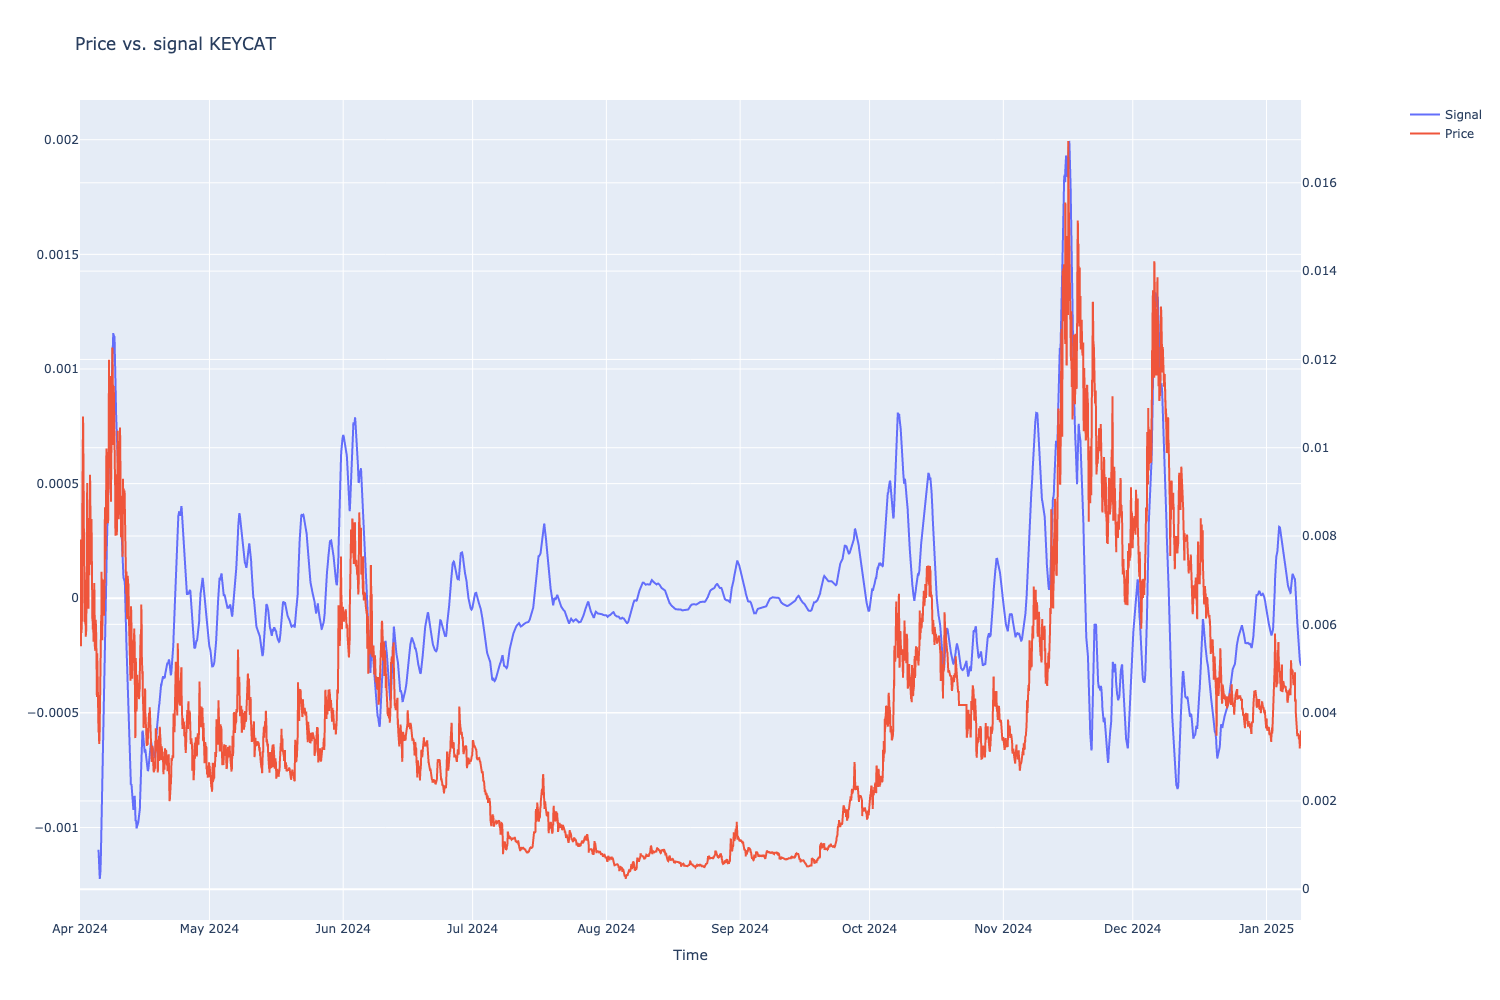

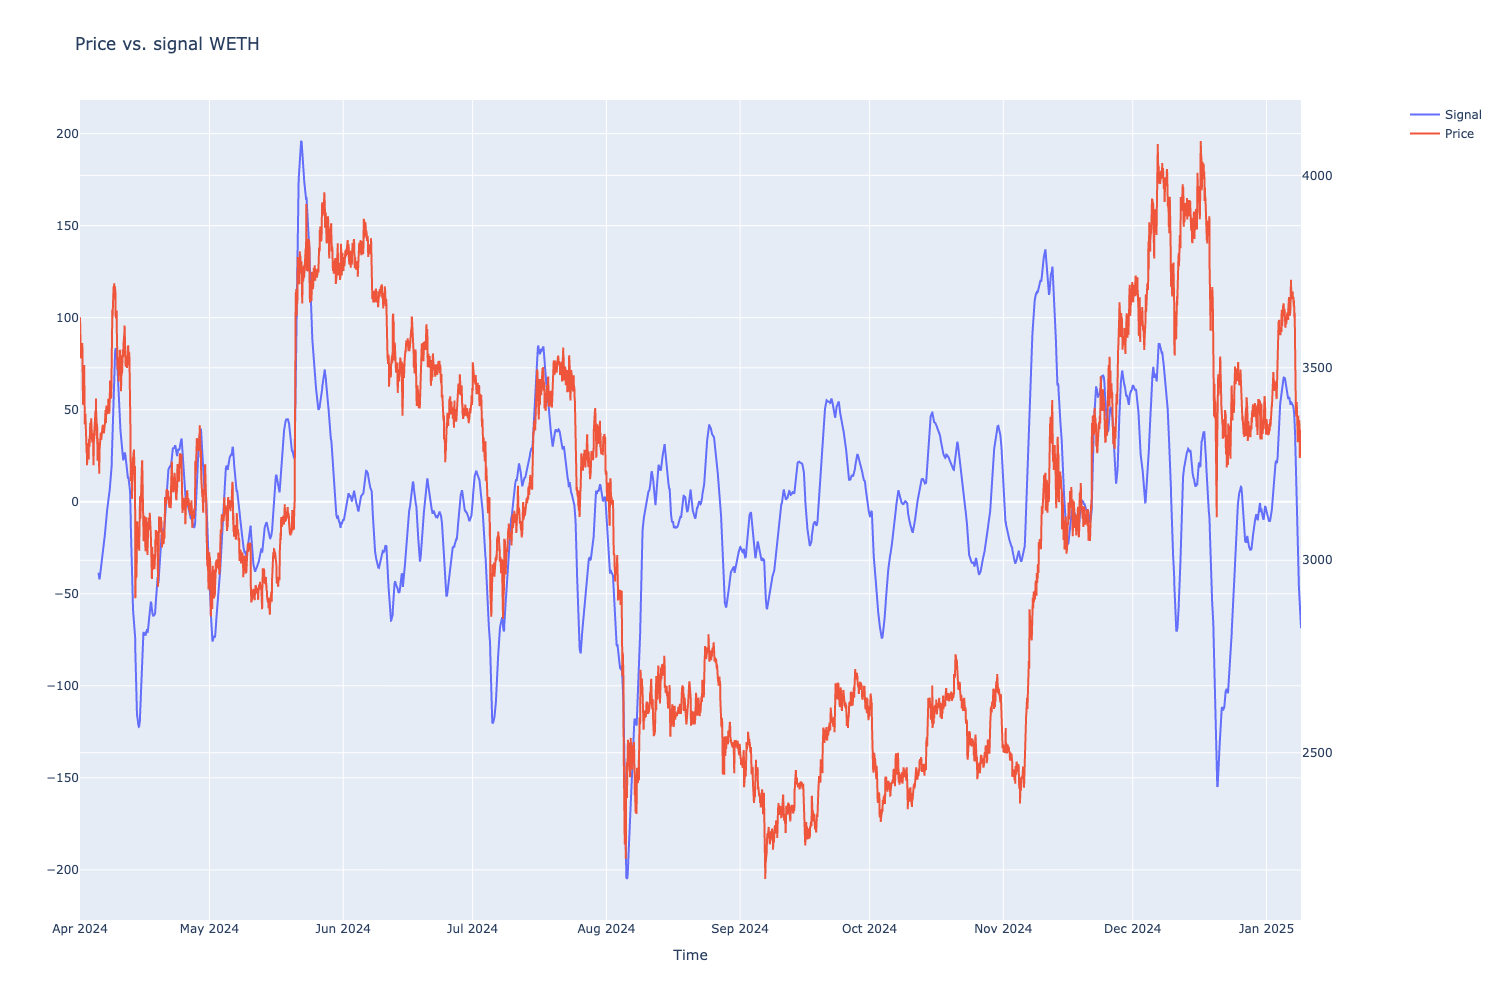

In [42]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

selected_assets = EXAMINED_ASSETS

# TODO: Plotly refuses correctly to plot the third y-axis
for symbol in selected_assets:
    pair = token_map[symbol]
    price = strategy_universe.data_universe.candles.get_candles_by_pair(pair.internal_id)["close"]
    signal = indicator_data.get_indicator_series("signal", pair=pair)    
    volatility = indicator_data.get_indicator_series("volatility", pair=pair)

    df = pd.DataFrame({
        "price": price,
        "signal": signal,
        # "volatility": volatility,
    })

    fig = make_subplots(specs=[[{"secondary_y": True}]])

    fig.add_trace(
        go.Scatter(x=df.index, y=df["signal"], name="Signal"),
        secondary_y=False,        
    )

    # fig.add_trace(
    #    go.Scatter(x=df.index, y=df["volatility"], name="Volatility", yaxis="y2"),
    #    secondary_y=True,
    #)

    fig.add_trace(
        go.Scatter(x=df.index, y=df["price"], name="Price", yaxis="y3"),
        secondary_y=True,        
    )

    fig.update_layout(title=f"Price vs. signal {symbol}")
    fig.update_layout(showlegend=True)
    fig.update_xaxes(title="Time")
    # fig.update_layout(
    #    yaxis_type="log"   
    #)
    

    fig.show()
    

# Backtest time range

- Choose the backtesting time range
- Start when we have enough assets (`Parameters.min_asset_universe`) in our asset universe to form the first basket

In [43]:
series = indicator_data.get_indicator_series("all_criteria_included_pair_count")

exceeds_threshold = series > Parameters.min_asset_universe
# Get the first date where the condition is True
backtest_start = Parameters.backtest_start
backtest_end = Parameters.backtest_end

print(f"Time range is {backtest_start} - {backtest_end}")

Time range is 2024-04-01 00:00:00 - 2025-01-09 00:00:00


# Strategy algorithm and backtest

- Run the backtest

In [ ]:
from tradeexecutor.backtest.backtest_runner import run_backtest_inline
from tradeexecutor.strategy.alpha_model import AlphaModel
from tradeexecutor.state.trade import TradeExecution
from tradeexecutor.strategy.pandas_trader.strategy_input import StrategyInput, IndicatorDataNotFoundWithinDataTolerance
from tradeexecutor.state.visualisation import PlotKind
from tradeexecutor.backtest.backtest_runner import run_backtest_inline
from tradeexecutor.strategy.tvl_size_risk import USDTVLSizeRiskModel
from tradeexecutor.strategy.weighting import weight_by_1_slash_n, weight_passthrouh, weight_equal
from tradeexecutor.utils.dedent import dedent_any


def decide_trades(
    input: StrategyInput
) -> list[TradeExecution]:
    """For each strategy tick, generate the list of trades."""
    parameters = input.parameters
    position_manager = input.get_position_manager()
    state = input.state
    timestamp = input.timestamp
    indicators = input.indicators
    strategy_universe = input.strategy_universe

    # Build signals for each pair 
    alpha_model = AlphaModel(
        timestamp,
        close_position_weight_epsilon=parameters.min_portfolio_weight,  # 10 BPS is our min portfolio weight
    )

    # Prepare diagnostics variables
    max_vol = (0, None)  
    signal_count = 0  
    vol_pair = strategy_universe.get_pair_by_human_description(VOL_PAIR)
    volume_included_pair_count = indicators.get_indicator_value(
        "volume_included_pair_count",
    )
    volatility_included_pair_count = indicators.get_indicator_value(
        "volatility_included_pair_count",
    ) 
    tvl_included_pair_count = indicators.get_indicator_value(
        "tvl_included_pair_count",
    )
    
    # Get pairs included in this rebalance cycle.
    # This includes pair that have been pre-cleared in inclusion_criteria()
    # with volume, volatility and TVL filters 
    included_pairs = indicators.get_indicator_value(
        "inclusion_criteria",
        na_conversion=False,
    )
    if included_pairs is None:
        included_pairs = []

    clipped_pairs = 0

    # Set signal for each pair
    for pair_id in included_pairs:
        pair = strategy_universe.get_pair_by_id(pair_id)

        pair_signal = indicators.get_indicator_value("signal", pair=pair)
        if pair_signal is None:
            continue

        weight = pair_signal 

        if weight < 0:
            continue
    
        alpha_model.set_signal(
            pair,
            weight,
        )

        # Diagnostics reporting
        signal_count += 1


    # Calculate how much dollar value we want each individual position to be on this strategy cycle,
    # based on our total available equity
    portfolio = position_manager.get_current_portfolio()
    portfolio_target_value = portfolio.get_total_equity() * parameters.allocation

    # Select max_assets_in_portfolio assets in which we are going to invest
    # Calculate a weight for ecah asset in the portfolio using 1/N method based on the raw signal
    alpha_model.select_top_signals(count=parameters.max_assets_in_portfolio)
    alpha_model.assign_weights(method=weight_passthrouh)
    # alpha_model.assign_weights(method=weight_by_1_slash_n)

    #
    # Normalise weights and cap the positions
    # 
    size_risk_model = USDTVLSizeRiskModel(
        pricing_model=input.pricing_model,
        per_position_cap=parameters.per_position_cap_of_pool,  # This is how much % by all pool TVL we can allocate for a position
        missing_tvl_placeholder_usd=parameters.assummed_liquidity_when_data_missings,  # Placeholder for missing TVL data until we get the data off the chain
    )

    alpha_model.normalise_weights(
        investable_equity=portfolio_target_value,
        size_risk_model=size_risk_model,
        max_weight=parameters.max_concentration,
    )

    # Load in old weight for each trading pair signal,
    # so we can calculate the adjustment trade size
    alpha_model.update_old_weights(
        state.portfolio,
        ignore_credit=True,
    )
    alpha_model.calculate_target_positions(position_manager)

    # Shift portfolio from current positions to target positions
    # determined by the alpha signals (momentum)
    
    # rebalance_threshold_usd = portfolio_target_value * parameters.min_rebalance_trade_threshold_pct
    rebalance_threshold_usd = parameters.individual_rebalance_min_threshold_usd
    
    assert rebalance_threshold_usd > 0.1, "Safety check tripped - something like wrong with strat code"
    trades = alpha_model.generate_rebalance_trades_and_triggers(
        position_manager,
        min_trade_threshold=rebalance_threshold_usd,  # Don't bother with trades under XXXX USD
        invidiual_rebalance_min_threshold=parameters.individual_rebalance_min_threshold_usd,
        execution_context=input.execution_context,
    )

    # Supply or withdraw cash to Aave if strategy is set to do so
    if parameters.use_aave:
        credit_deposit_flow = position_manager.calculate_credit_flow_needed(
            trades,
            parameters.allocation,
        )
        trades += position_manager.manage_credit_flow(credit_deposit_flow)
    else:
        credit_deposit_flow = 0

    # Add verbal report about decision made/not made,
    # so it is much easier to diagnose live trade execution.
    # This will be readable in Discord/Telegram logging.
    if input.is_visualisation_enabled():
        try:
            top_signal = next(iter(alpha_model.get_signals_sorted_by_weight()))
            if top_signal.normalised_weight == 0:
                top_signal = None
        except StopIteration:
            top_signal = None

        max_vol_pair = max_vol[1]
        if max_vol_pair:
            max_vol_signal = alpha_model.get_signal_by_pair(max_vol_pair)
        else:
            max_vol_signal = None

        vol_pair_vol = indicators.get_indicator_value("volatility_ewm", pair=vol_pair)

        rebalance_volume = sum(t.get_value() for t in trades)
        
        report = dedent_any(f"""
        Cycle: #{input.cycle}
        Rebalanced: {'👍' if alpha_model.is_rebalance_triggered() else '👎'}
        Open/about to open positions: {len(state.portfolio.open_positions)} 
        Max position value change: {alpha_model.max_position_adjust_usd:,.2f} USD
        Rebalance threshold: {alpha_model.position_adjust_threshold_usd:,.2f} USD
        Trades decided: {len(trades)}
        Pairs total: {strategy_universe.data_universe.pairs.get_count()}
        Pairs meeting inclusion criteria: {len(included_pairs)}
        Pairs meeting volume inclusion criteria: {volume_included_pair_count}
        Pairs meeting volatility inclusion criteria: {volatility_included_pair_count}        
        Pairs meeting TVL inclusion criteria: {tvl_included_pair_count}        
        Pairs under volatility threshold: {clipped_pairs}        
        Signals created: {signal_count}
        Total equity: {portfolio.get_total_equity():,.2f} USD
        Cash: {position_manager.get_current_cash():,.2f} USD
        Investable equity: {alpha_model.investable_equity:,.2f} USD
        Accepted investable equity: {alpha_model.accepted_investable_equity:,.2f} USD
        Allocated to signals: {alpha_model.get_allocated_value():,.2f} USD
        Discarted allocation because of lack of lit liquidity: {alpha_model.size_risk_discarded_value:,.2f} USD
        Credit deposit flow: {credit_deposit_flow:,.2f} USD
        Rebalance volume: {rebalance_volume:,.2f} USD
        {vol_pair.base.token_symbol} volatility: {vol_pair_vol}        
        Most volatility pair: {max_vol_pair.get_ticker() if max_vol_pair else '-'}
        Most volatility pair vol: {max_vol[0]}
        Most volatility pair signal value: {max_vol_signal.signal if max_vol_signal else '-'}
        Most volatility pair signal weight: {max_vol_signal.raw_weight if max_vol_signal else '-'}        
        """)

        # Most volatility pair signal weight (normalised): {max_vol_signal.normalised_weight * 100 if max_vol_signal else '-'} % (got {max_vol_signal.position_size_risk.get_relative_capped_amount() * 100 if max_vol_signal else '-'} % of asked size)
        if top_signal:
            top_signal_vol = indicators.get_indicator_value("volatility_ewm", pair=top_signal.pair)
            assert top_signal.position_size_risk
            report += dedent_any(f"""
            Top signal pair: {top_signal.pair.get_ticker()}
            Top signal volatility: {top_signal_vol}
            Top signal value: {top_signal.signal}
            Top signal weight: {top_signal.raw_weight}
            Top signal weight (normalised): {top_signal.normalised_weight * 100:.2f} % (got {top_signal.position_size_risk.get_relative_capped_amount() * 100:.2f} % of asked size)
            """)            

        for flag, count in alpha_model.get_flag_diagnostics_data().items():
            report += f"Signals with flag {flag.name}: {count}\n"

        state.visualisation.add_message(
            timestamp,
            report, 
        )

        state.visualisation.set_discardable_data("alpha_model", alpha_model)
    
    return trades  # Return the list of trades we made in this cycle


result = run_backtest_inline(
    name=parameters.id,
    engine_version="0.5",
    decide_trades=decide_trades,
    create_indicators=indicators.create_indicators,
    client=client,
    universe=strategy_universe,
    parameters=parameters,
    # log_level=logging.INFO,
    max_workers=1,
    start_at=backtest_start,
    end_at=backtest_end,
)

state = result.state

trade_count = len(list(state.portfolio.get_all_trades()))
print(f"Backtesting completed, backtested strategy made {trade_count} trades")

Reading cached indicators trailing_sharpe, trailing_sharpe_ewm, volatility, rolling_returns, macd, signal, vol…

Using indicator cache /Users/moo/.cache/indicators/base_1h_60_2024-04-01-2025-01-09_ff


  0%|          | 0/24451200 [00:00<?, ?it/s]

IndicatorNotFound: Indicator with name 'avg_signal' not defined by create_indicators(). Available indicators are: trailing_sharpe, trailing_sharpe_ewm, volatility, rolling_returns, macd, signal, volatility_ewm, mean_returns, rolling_cumulative_volume, rolling_liquidity_avg, volume_inclusion_criteria, volatility_inclusion_criteria, tvl, tvl_ewm, tvl_inclusion_criteria, trading_availability_criteria, inclusion_criteria, volume_included_pair_count, volatility_included_pair_count, tvl_included_pair_count, all_criteria_included_pair_count, trading_pair_count, volume_weighted_avg_volatility

# Performance metrics

- Display portfolio performance metrics
- Compare against buy and hold matic using the same initial capital

**Note**: Some of these metrics might be incorrect due to slow start of the strategy

In [14]:
from tradeexecutor.analysis.multi_asset_benchmark import compare_strategy_backtest_to_multiple_assets

compare_strategy_backtest_to_multiple_assets(
    state,
    strategy_universe,
    display=True,
    interesting_assets=EXAMINED_ASSETS,
)

Strategy                AIXBT  \
Start Period                        2024-04-01           2024-04-01   
End Period                          2025-01-08           2025-01-08   
Risk-Free Rate                            0.0%                 0.0%   
Time in Market                           97.0%                17.0%   
Cumulative Return                    1,036.96%              833.14%   
CAGR﹪                                  777.87%               635.8%   
Sharpe                                    4.68                 2.62   
Prob. Sharpe Ratio                      100.0%               99.75%   
Smart Sharpe                              3.69                 2.09   
Sortino                                  14.41                 6.15   
Smart Sortino                            11.35                  4.9   
Sortino/√2                               10.19                 4.35   
Smart Sortino/√2                          8.02                 3.47   
Omega                                     3.13                 3.21   
Max Drawdown                            -16.6%              -40.05%   
Longest DD Days                             82                   11   
Volatility (ann.)                       72.41%              146.18%   
Calmar                                   46.87                15.87   
Skew                                      2.89                 2.88   
Kurtosis                                 13.37                 15.6   
Expected Daily                           0.86%                0.79%   
Expected Monthly                        27.52%               25.02%   
Expected Yearly                        237.19%              205.47%   
Kelly Criterion                         51.59%               46.54%   
Risk of Ruin                              0.0%                 0.0%   
Daily Value-at-Risk                      -5.3%              -11.53%   
Expected Shortfall (cVaR)                -5.3%              -11.53%   
Max Consecutive Wins                        61                    6   
Max Consecutive Losses                       4                    5   
Gain/Pain Ratio                           2.13                 1.57   
Gain/Pain (1M)                           64.61                97.47   
Payoff Ratio                               1.0                 5.85   
Profit Factor                             3.13                 2.57   
Common Sense Ratio                        9.43                12.09   
CPC Index                                 2.37                 8.16   
Tail Ratio                                3.01                 4.71   
Outlier Win Ratio                         9.26                12.84   
Outlier Loss Ratio                         2.9                 1.11   
MTD                                      2.42%               -8.68%   
3M                                     226.51%              833.14%   
6M                                     360.55%              833.14%   
YTD                                      2.42%               -8.68%   
1Y                                    1036.96%              833.14%   
3Y (ann.)                              777.87%               635.8%   
5Y (ann.)                              777.87%               635.8%   
10Y (ann.)                             777.87%               635.8%   
All-time (ann.)                        777.87%               635.8%   
Best Day                                28.07%               47.41%   
Worst Day                               -8.49%              -27.21%   
Best Month                              83.79%              328.25%   
Worst Month                             -2.88%               -8.68%   
Best Year                             1010.07%              921.83%   
Worst Year                               2.42%               -8.68%   
Avg. Drawdown                            -5.7%              -19.44%   
Avg. Drawdown Days                          13                    5   
Recovery Factor                          15.85                

# Equity curve

- Equity curve shows how your strategy accrues value over time

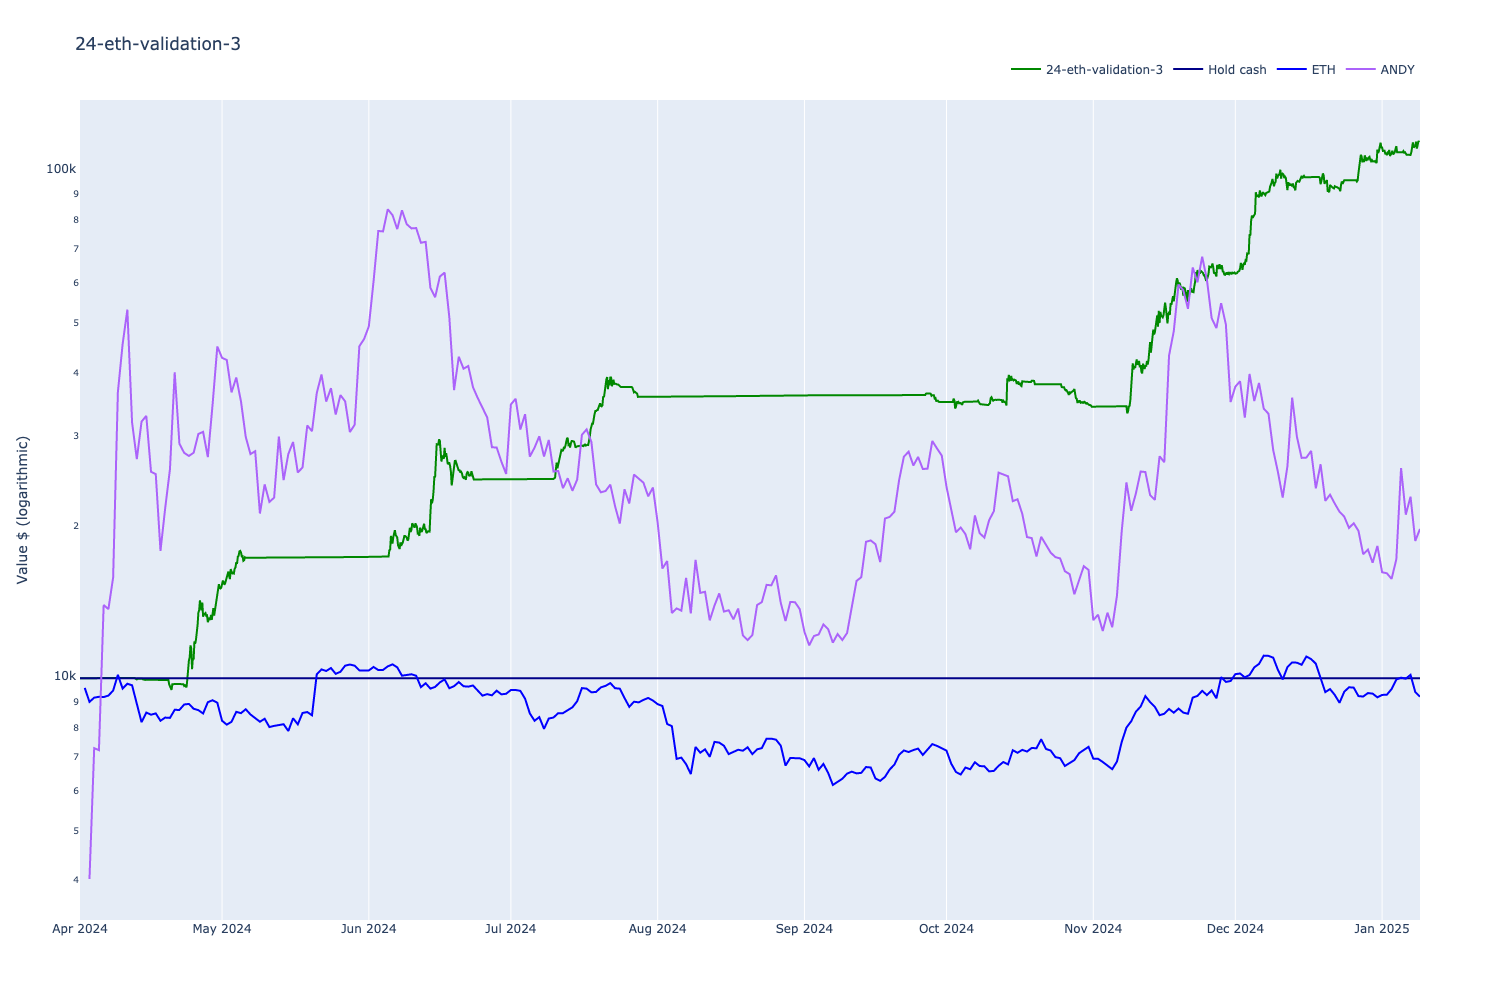

In [15]:
import pandas as pd
from tradeexecutor.analysis.multi_asset_benchmark import get_benchmark_data
from tradeexecutor.visual.benchmark import visualise_equity_curve_benchmark

benchmark_indexes = get_benchmark_data(
    strategy_universe,
    cumulative_with_initial_cash=state.portfolio.get_initial_cash(),
    max_count=4,
    start_at=state.get_trading_time_range()[0],
    interesting_assets=["WETH", "ANDY", "weirdo"],
)

fig = visualise_equity_curve_benchmark(
    state=state,    
    benchmark_indexes=benchmark_indexes,
    height=800,
    log_y=True,
)

fig.show()

## Equity curve with drawdown

- Linear curve

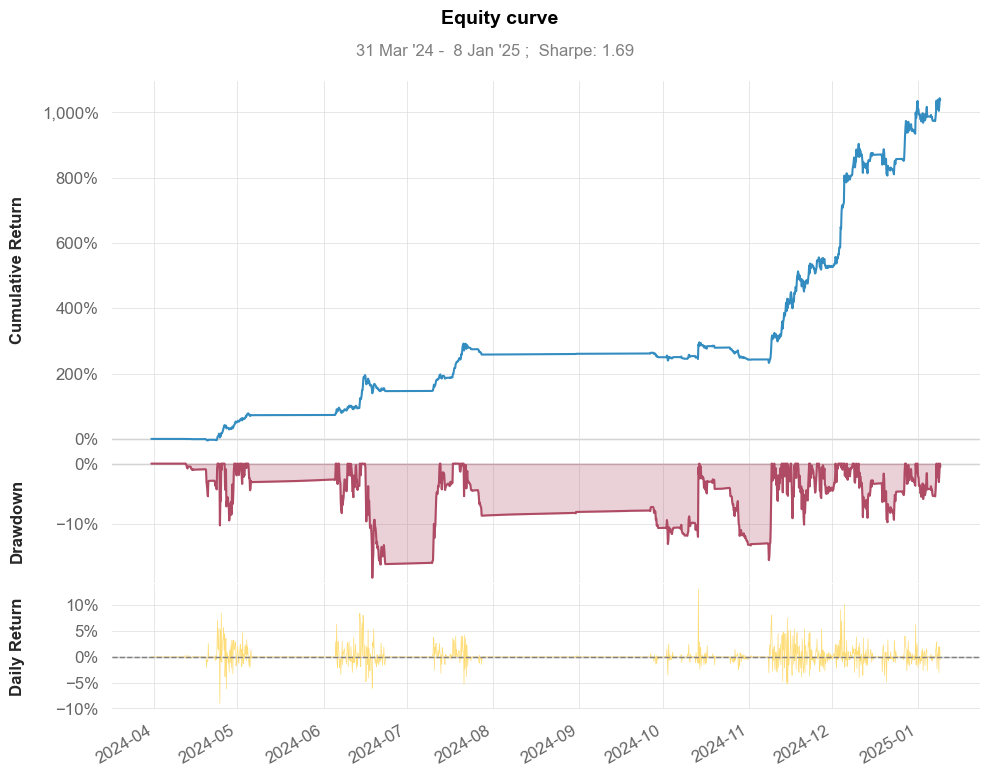

In [16]:
from tradeexecutor.visual.equity_curve import calculate_equity_curve, calculate_returns
from tradeexecutor.visual.equity_curve import visualise_equity_curve

curve = calculate_equity_curve(state)
returns = calculate_returns(curve)
fig = visualise_equity_curve(returns)
display(fig)

# Asset weights

- What assets were allocated over time
- Do both proportional % and USD weights

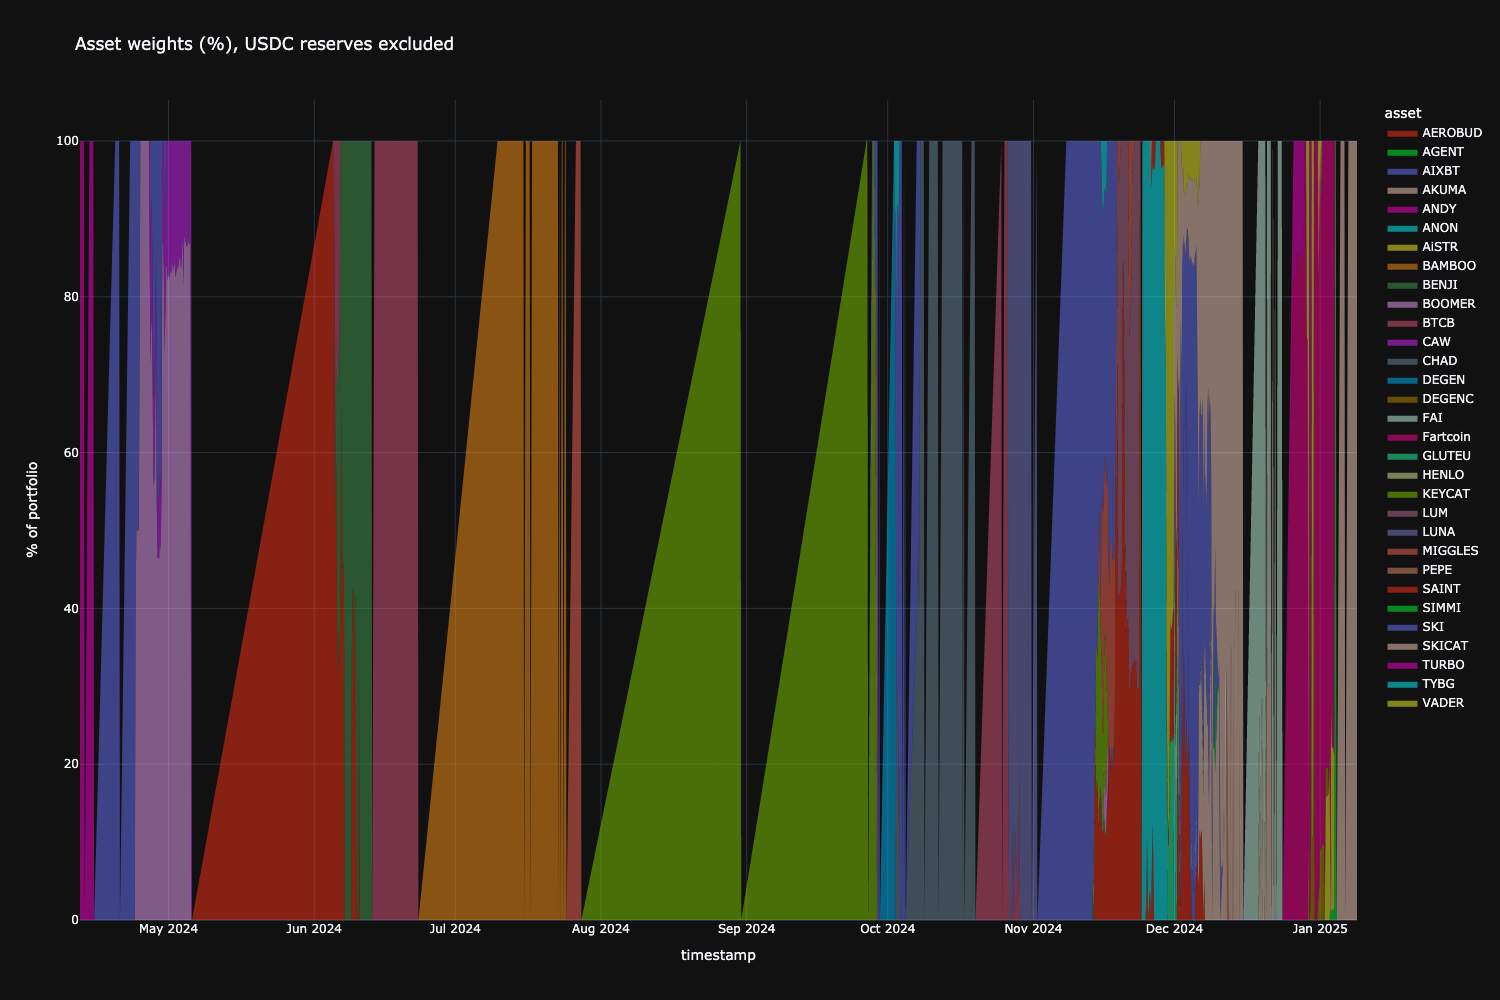

In [17]:
from tradeexecutor.analysis.weights import calculate_asset_weights, visualise_weights

weights_series = calculate_asset_weights(state)

fig = visualise_weights(
    weights_series,
    normalised=True,
    include_reserves=False,
)
fig.show()

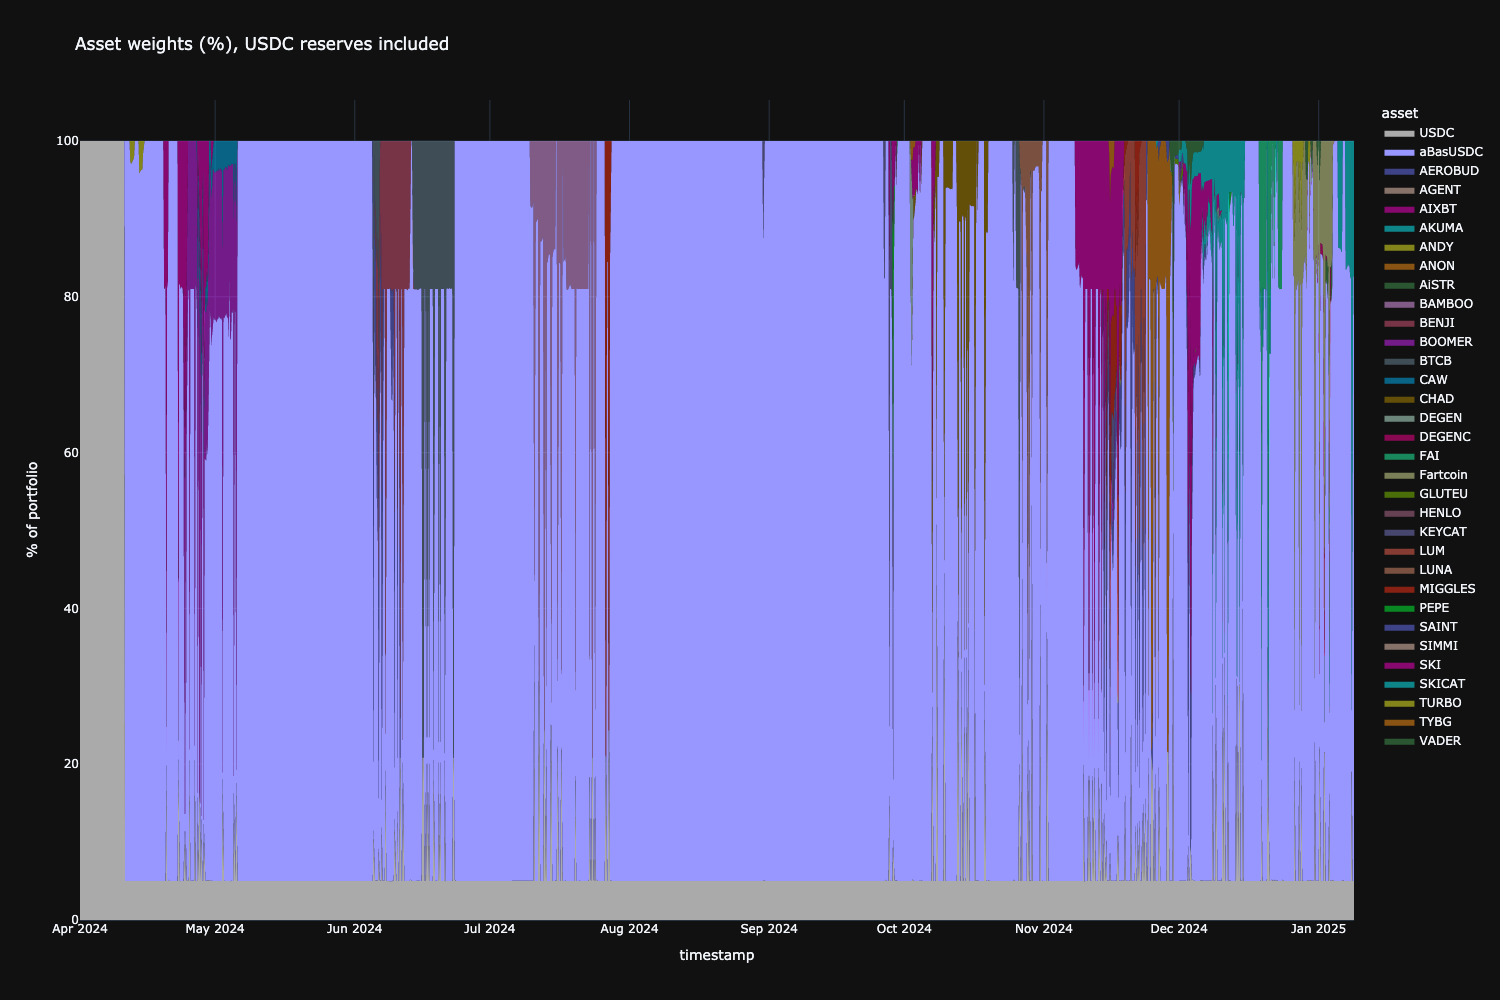

In [18]:

fig = visualise_weights(
    weights_series,
    normalised=True,
    include_reserves=True,
)
fig.show()

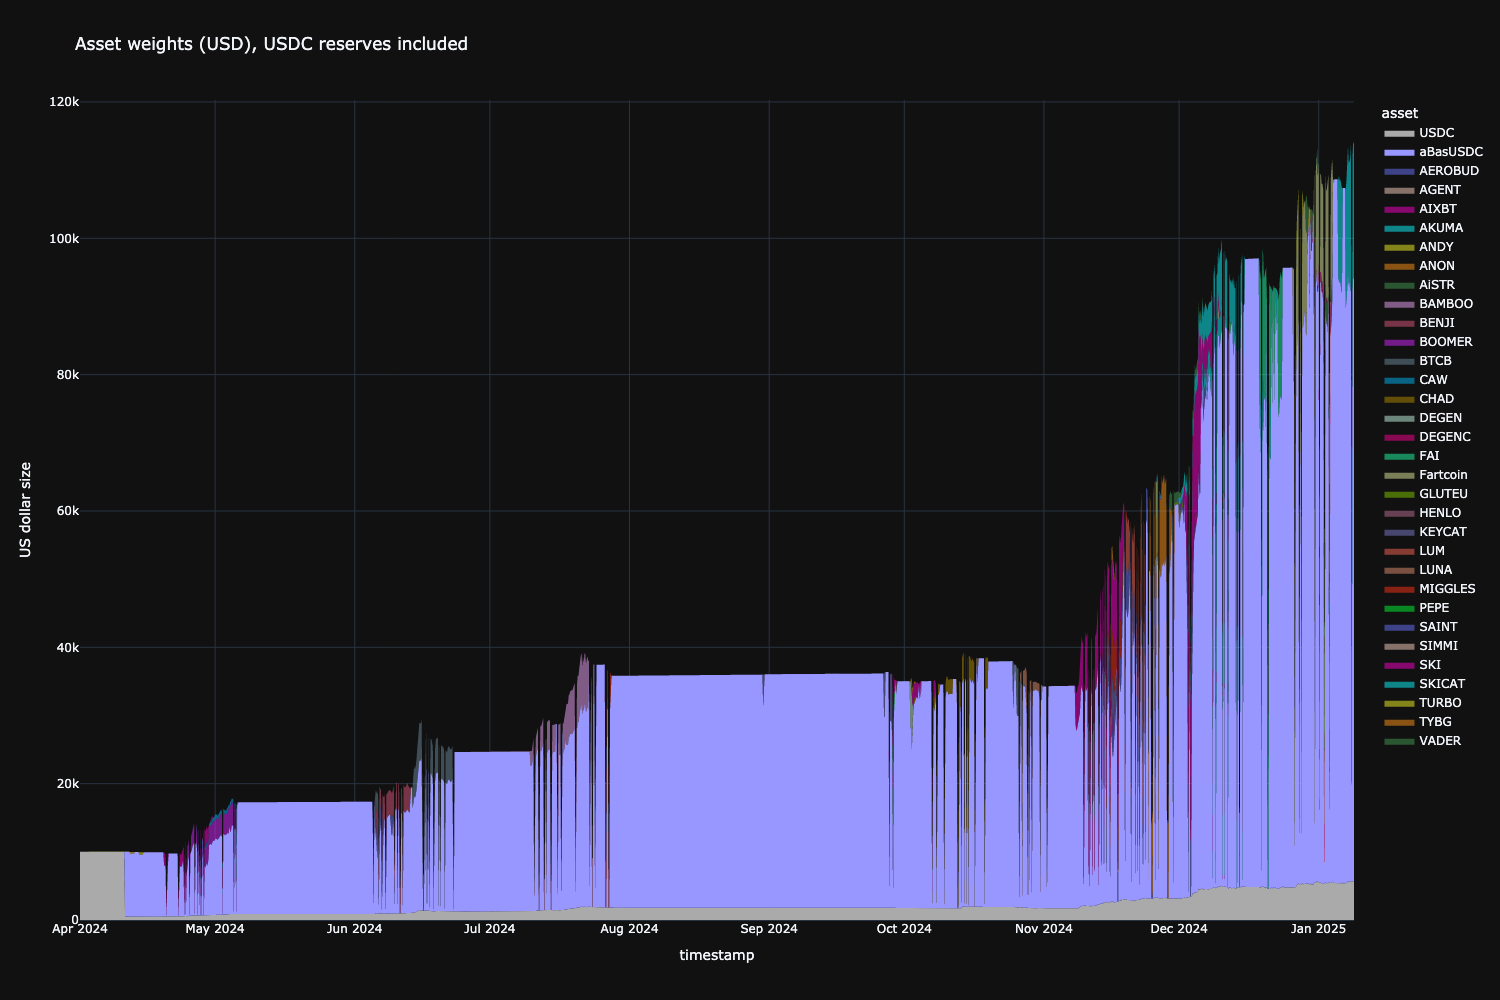

In [19]:
df = weights_series.unstack(level=1)

fig = visualise_weights(
    weights_series,
    normalised=False,
)
fig.show()

## Weight allocation statistics



In [20]:
from tradeexecutor.analysis.weights import calculate_weights_statistics

stats = calculate_weights_statistics(weights_series)
display(stats)


At      Pair       Value Unit
Name                                                                          
Max position (excluding USDC)   2025-01-05 04:00:00  aBasUSDC  103,241.81  USD
Min position (excluding USDC)   2024-10-27 20:00:00      BTCB       21.15  USD
Mean position (excluding USDC)                                  20,446.37  USD
Max position (excluding USDC)   2024-04-11 00:00:00  aBasUSDC      100.00    %
Min position (excluding USDC)   2024-10-27 20:00:00      BTCB        0.06    %
Mean position (excluding USDC)                                      57.92    %
Max position (including USDC)   2024-04-01 00:00:00      USDC      100.00    %
Min position (including USDC)   2024-10-27 20:00:00      BTCB        0.06    %
Mean position (including USDC)                                      37.52    %

# Positions at the end

Some example positions at the end


In [21]:

for p in list(state.portfolio.open_positions.values())[0:10]:
    print(f"Position {p.pair.base.token_symbol}, value {p.get_value()} USD")

Position AKUMA, value 19807.42726316338 USD
Position aBasUSDC, value 88203.48730146438 USD


Examples of strategy thinking output 

- At the end of strategy
- Reverse order - last timestamp first

In [22]:
messages = state.visualisation.get_messages_tail(2)

table = pd.Series(
    data=list(messages.values()),
    index=list(messages.keys()),
)

df = table.to_frame()

display(df.style.set_properties(**{
    'text-align': 'left',
    'white-space': 'pre-wrap',
}))


# Alpha model diagnostics data

- Dump out alpha model contents from the last cycle

In [23]:
from tradeexecutor.strategy.alpha_model import format_signals

alpha_model = state.visualisation.discardable_data["alpha_model"]

print(f"All signals ({len(df)})")
df = format_signals(alpha_model, signal_type="all")
display(df)

All signals (2)


Signal    Asked size  Accepted size  Value adjust USD  \
Pair                                                                  
AKUMA-WETH  0.127691  21602.865614   19810.840768         570.62427   

            Weights (raw)  Weights (norm/cap)  Old weight Flipping      TVL  \
Pair                                                                          
AKUMA-WETH       0.127691                 1.0     0.17821  no flip  1981084   

                                                   Flags  
Pair                                                      
AKUMA-WETH  capped_by_pool_size, capped_by_concentration

# Trading pair breakdown

- Trade success for each trading pair



In [24]:
from tradeexecutor.analysis.multipair import analyse_multipair
from tradeexecutor.analysis.multipair import format_multipair_summary

multipair_summary = analyse_multipair(state)
format_multipair_summary(multipair_summary, sort_column="Total return %")

# Trading metrics

- Trading cost, etc.

In [25]:
from tradeexecutor.analysis.trade_analyser import build_trade_analysis

analysis = build_trade_analysis(state.portfolio)
summary = analysis.calculate_summary_statistics()
display(summary.to_dataframe())

# Credit metrics

- How much we get out from Aave

In [26]:
from tradeexecutor.analysis.credit import calculate_credit_metrics

interest_df = calculate_credit_metrics(state)
display(interest_df)

Value
Name                                           
Credit position count                       308
Total interest earned              2,141.09 USD
Avg interest                              9.02%
Min interest                              0.00%
Max interest                             27.29%
Avg credit position duration    21:19:44.364821
Total deposit flow in         24,724,106.61 USD
Min deposit                            0.32 USD
Avg deposit                       23,171.61 USD
Max deposit                      103,244.95 USD